# Adaptive Ratchets

(c) 2024 Tom Röschinger and Michael Lässig. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In this notebook we produce all computational figures for the paper "Adaptive ratchets and the evolution of molecular complexity". Run on Julia 1.10.5.

Import Packages.

In [2]:
using CairoMakie, Random, StatsBase, Polynomials, NLsolve, DataFrames, Colors

Set plotting theme.

In [3]:
# Find paths for fonts, if not found, add to Makie
Font = assetpath("fonts", "Lucida-Sans-Unicode-Regular.ttf")
Font_bold = assetpath("fonts", "Lucida-Sans-Bold.otf")

# Set theme
theme = Theme(
    Axis = (
        # Font sizes
        titlesize=10,
        xlabelsize=9,
        ylabelsize=9,
        xticklabelsize=8,
        yticklabelsize=8,

        # Font styles
        titlefont=Font,
        xticklabelfont=Font,
        yticklabelfont=Font,
        xlabelfont=Font,
        ylabelfont=Font
        ),
    Legend = (
            titlesize=8,
            labelsize=8,
            rowgap=-5,
            labelfont=Font

        ),
        backgroundcolor="white",
        linewidth=1.25,

    )
set_theme!(theme)

## Global Parameters

In [4]:
# Parameters
gap = 5
l0 = 10

# Energy per mismatch
ϵ0 = gap/l0

# Population size
N = 100000

# Complexity cost
c0 = 1/2N

# Recognition fitness
f0 = 100*l0/2N

# Relative mutation rate for length changes
ν = 0.1

# Alphabet size
n = 4

4

## Fitness

Now we define the fitness landscape. First, we compute the half binding point as 
$$
    \gamma_{50}(\ell, n) = \gamma_0 + \frac{1}{\epsilon_0 \ell} \frac{\Delta G_{50}}{k_B T},
$$
with 
$$
\frac{\Delta G_{50}}{k_B T} = \epsilon_0 \ell_0 + \frac{(\ell - \ell_{\min})}{\epsilon_0 \ell} \log \left[ \gamma_0 {e}^{(1 - \gamma_0) \, \epsilon_0} +  
(1 - \gamma_0) \, {e}^{- \gamma_0 \epsilon_0} \right] ,
$$
where $\gamma_0 = 1/n$ is the average coding density of a random site. For short sites, the half binding point can be approximated as 
$$
    \gamma_{50}(\ell, n) = \gamma_0(n) + \frac{\ell_0}{\ell},
$$
since the correction is of order 0.1.

In [5]:
# Correction factor
fann(l0) = log(γ_0(n) * exp((1-γ_0(n)) * (gap/l0)) + (1 - γ_0(n)) * exp(-γ_0(n) * (gap/l0)))

# Minimum length of funcitonal sites
lmin(l0) = ceil(l0 * (gap + 1) / ((1 - γ_0(n) - (l0/gap) * fann(l0)) * gap)) 

γ_0(n) = 1/n

γ50(l, l0=l0) = γ_0(n) + l0 / l + (l - lmin(l0)) / (l * gap/l0) * fann(l0)

γ50_app(l) = γ_0(n) + l0/l

γ50_app (generic function with 1 method)

Plot the half binding point and its approximation.

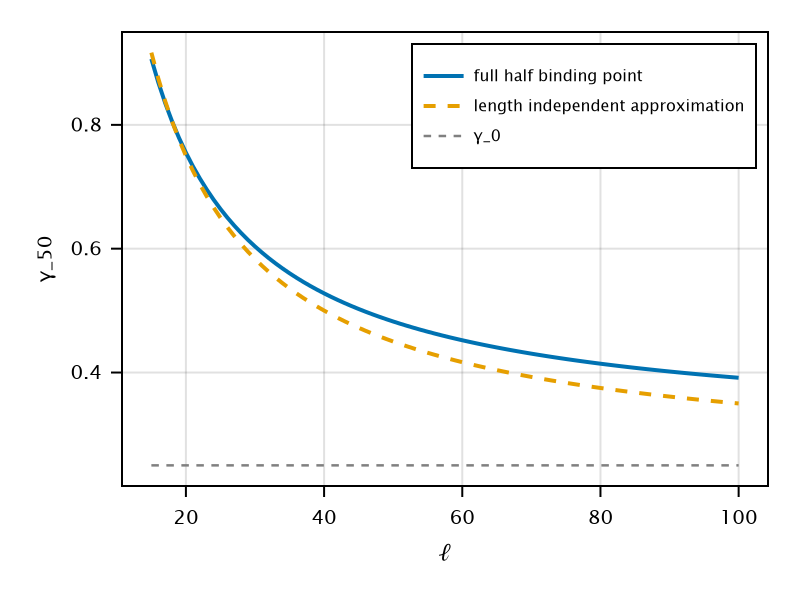

In [6]:
# Initate Figure
fig = Figure(size=(400, 300))
ax = Axis(
    fig[1, 1],
    xlabel="ℓ",
    ylabel="γ_50",
    xticklabelsize=10,
    yticklabelsize=10,
    xlabelsize=10,
    ylabelsize=10
    )
lines!(ax, 15:100, [γ50(l) for l in 15:100], label="full half binding point", linewidth=2)
lines!(ax, 15:100, [γ50_app(l) for l in 15:100], linestyle=:dash, label="length independent approximation", linewidth=2)
lines!(ax, 15:100, [γ_0(n) for l in 15:100], linestyle=:dash, label="γ_0", color="gray")
axislegend(position=:rt)
#save("half_binding_correction.pdf", fig)
fig

Having defined the half binding point, we can define the fitness landscape as the following,
$$
    F(\gamma, \ell) = \frac{f_0}{1+\exp\left[ -\epsilon_0 \ell (\gamma - \gamma_{50}(\ell)) \right]} - c_0\ell.
$$

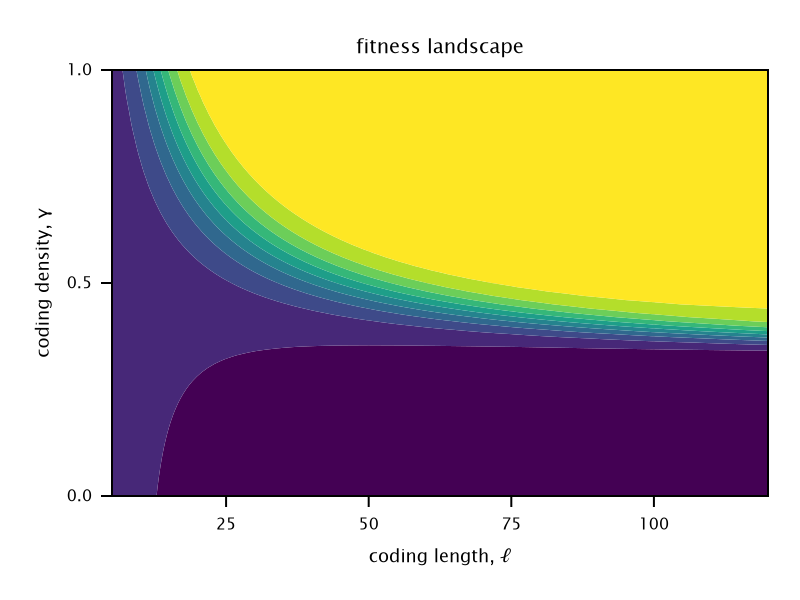

In [8]:
# Fitness
Fitness(γ, l, c=c0) = f0 / (1 + exp(-gap * l/l0* (γ - γ50(l)))) - c * l

# Plot fitness landscape
F = hcat([[Fitness(γ, l, c0)  for l in 5:120] for γ in 0:0.01:1]...)

# Initate Figure
fig = Figure(size=(400, 300))
ax = Axis(fig[1, 1])

# Make contour plot
contourf!(ax, 5:120, 0:0.01:1, F)

# Annotate plot
ax.xlabel = "coding length, ℓ"
ax.ylabel = "coding density, γ"
ax.title = "fitness landscape"

fig

## Free Fitness

Combining the fitness landscape with entropy (the distribution of random sites) gives the free fitness $\Psi$,
$$
    \Psi(\gamma, \ell) = S(\gamma, \ell) + 2NF(\gamma, \ell),
$$
with
$$
    S(\gamma, \ell) = \binom{\ell}{\gamma \ell} \left(\frac{1}{n}\right)^{\gamma \ell} \left(\frac{n-1}{n}\right)^{1-\gamma\ell}.
$$


binomial_big (generic function with 1 method)

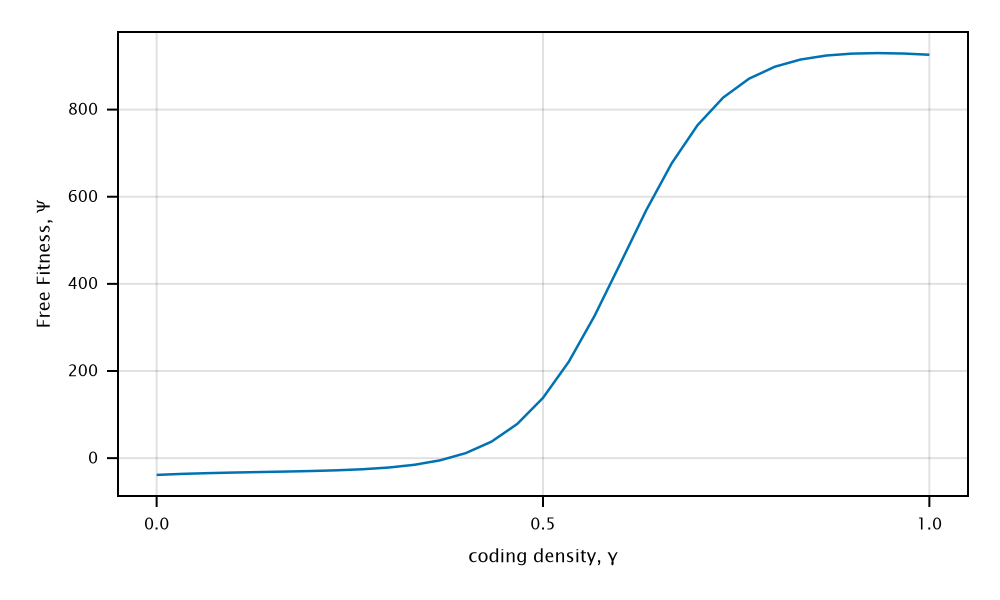

In [9]:
# Binomial coefficient for large numbers
binomial_big(n,k) = binomial(big(n),k)

# Entropy
H(γ, l) = log(binomial_big(l, Int64(floor(γ*l))) *  γ_0(n)^(γ * l) * (1 - γ_0(n))^((1 - γ) * l))

# Initiate figure
fig = Figure(size=(500, 300))
ax = Axis(fig[1, 1])

# Make plot
l_plot = 30
lines!(ax, 0:1/l_plot:1,  2N * Fitness.(collect(0:1/l_plot:1), l_plot) .+ H.(collect(0:1/l_plot:1), l_plot))

# Annotate figure
ax.xlabel = "coding density, γ"
ax.ylabel = "Free Fitness, Ψ"

# Display figure
fig

## Theoretical Computations

In [13]:
# Fixation probability from Kimura 1962
function kimura(s, N)
    if abs(s) > 10^-8
        return (1-exp(-2s)) / (1-exp(-2N * s))
    else
        return 1/N
    end
end

g(γ, l) = N * kimura(γ, N)


# Substitution rate for trate increasing mutations
function up(γ, l::Int64, κ, N::Int64=N)
    if γ < 1
        return γ_0(n) / (1 - γ_0(n)) * (1 - γ) * (g(Fitness(γ+1/l, l) - Fitness(γ, l), N) + κ)
    else
        return 0
    end
end


# Substitution rate for trate decreasing mutations
function um(γ, l::Int64, κ, N::Int64=N)
  if γ > 0
    return γ * (g(Fitness(γ-1/l, l) - Fitness(γ, l), N) + κ)
  else
    return 0
  end
end


## Edge cases for length mutations
# (k,l) -> (k+1,l+1)
γ_pp(γ, l) = min((γ + 1/l)/(1 + 1/l), 1)

# (k,l) -> (k,l+1)
γ_pm(γ, l) = max(γ /(1 + 1/l), 0)

# (k,l) -> (k,l-1)
γ_mp(γ, l) = min(γ/(1 - 1/l), 1)

# (k,l) -> (k-1,l-1)
γ_mm(γ, l) = max((γ - 1/l)/(1 - 1/l), 0)


## selection coeffcients for length increase and decrease
# (k,l) -> (k+1,l+1)
s_pp(γ, l) = Fitness(γ_pp(γ, l), l + 1) - Fitness(γ, l)

# (k,l) -> (k,l+1)
s_pm(γ, l) = Fitness(γ_pm(γ, l), l + 1) - Fitness(γ, l)

# (k,l) -> (k-1,l-1)
s_mm(γ, l) = Fitness(γ_mm(γ, l), l - 1) - Fitness(γ, l) 

# (k,l) -> (k,l-1)
s_mp(γ, l) = Fitness(γ_mp(γ, l), l - 1) - Fitness(γ, l)


# substitution rates of length increase and decrease
v_pp(γ, l) = γ_0(n) * g(s_pp(γ, l), N)

v_pm(γ, l) = (1 - γ_0(n)) * g(s_pm(γ, l), N)

v_plus(γ, l) = v_pp(γ, l) + v_pm(γ, l)

v_plus_SC(γ, l) = γ_0(n) * g(10 * maximum([s_pp(γ, l), -1]), N) / 10

v_plus_star(l, κ) = v_plus(γ_star(l, κ), l)

v_mm(γ, l) = γ * g(s_mm(γ, l), N) 

v_mp(γ, l) = (1 - γ) * g(s_mp(γ, l), N)

v_minus(γ, l) = v_mm(γ, l) + v_mp(γ, l) 

v_minus_SC(γ, l) = (1 - γ) * g(10* maximum([s_mp(γ, l), -1]), N) / 10

v_minus_star(l, κ) = v_minus(γ_star(l, κ), l)


# Inverse subsitution probability
function ginv(u)
  function f!(F, x)
      F[1] =  g(x[1], N) - u
  end
  x = nlsolve(f!, [0.5])
  return x.zero[1]
end


# Effective selective coefficients
seffplus(l, κ) = ginv(v_plus_star(l, κ))

seffminus(l, κ) = ginv(v_minus_star(l, κ))

seff(l, kappa) = log(v_plus_star(l - 1, κ) / v_minus_star(l, κ))


# Numerical free fitness
function Ψ_k(l::Int64, κ, N::Int64)
  plist = zeros(l+1)
  for i in 1:l
    plist[i+1] = plist[i] + log(up(i/l - 1/l, l, κ, N) / um(i/l, l, κ, N))
  end
  return collect(0:1/l:1), plist
end


# Trait that maximizes free fitness at given length
function γ_star(l::Int64, κ, N::Int64=N)
  γ_list, plist = Ψ_k(l, κ, N)
  if γ50(l) < 1
      gmax = argmax(plist)
      if gmax != length(plist)
        inds = collect(gmax-1:gmax+1)
        x = γ_list[inds]
        y = plist[inds]
        f = Polynomials.fit(x, y, 2)
        return - f[1] / 2f[2]
      else
        return 1
      end
  else 
      return 1
  end
end


γ_star (generic function with 2 methods)

### Compute theoretical predictions

First the approximation we had initially.

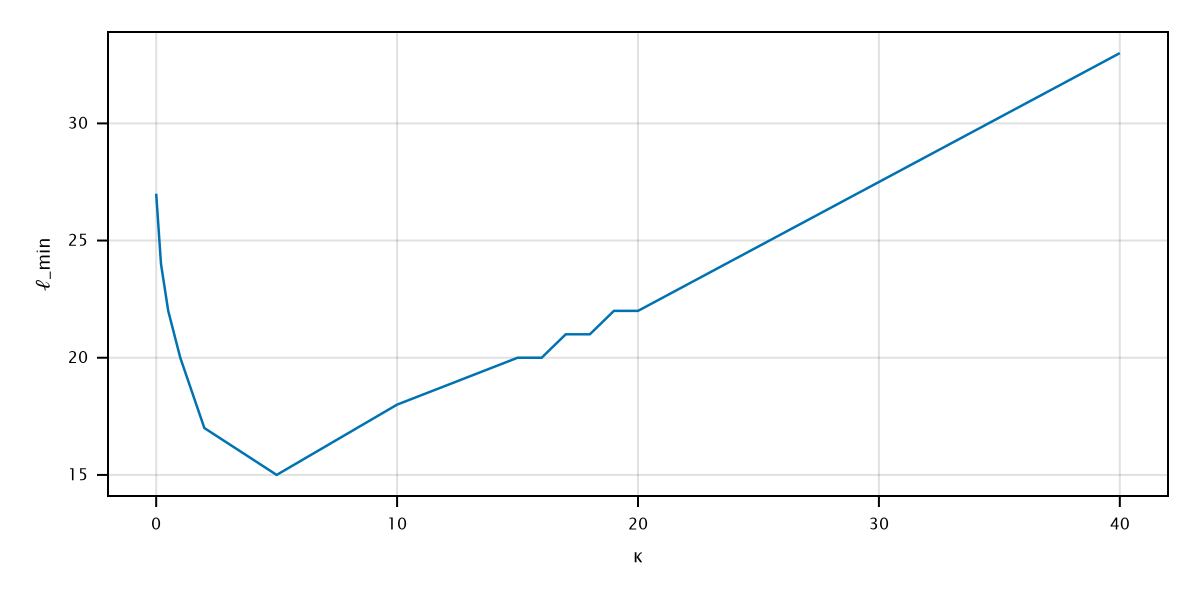

In [14]:
# Fitness with approximate half binding point
Fitness(γ, l, c=c0) = f0 / (1 + exp(-gap * l/l0* (γ - γ50_app(l)))) - c * l

# Find optimal length from length substitution rates
function lstar(κ, N=1000, lmax=300)
    # Get ML coding density
    gammastarlist = [γ_star(l,κ, N) for l in 1:lmax]
    # Get functional sites
    functposlist = [(1 > gammastarlist[i] > γ50_app(l))  for (i, l) in enumerate(1:lmax)]
    # Get coding density of functional sites
    gammafunclist = gammastarlist[functposlist]
    # Get minimal length of functional sites
    lm = findfirst(functposlist)
    
    # Get fitness at ML coding density
    flist = cumsum([log(v_plus(γ_star(l - 1, κ, N), l-1) / v_minus(γ_star(l, κ, N), l)) for l in lm:lmax])
    # Get fitness at ML coding density in strong driving regime
    flistSC = cumsum([log(v_plus_SC(γ_star(l - 1, κ, N), l-1) / v_minus_SC(γ_star(l, κ, N), l)) for l in lm:lmax])

    # ML code length
    lst = argmax(flist) + lm - 1
    # Effective selective coefficient for length increase mutation
    seffpluslist = [seffplus(l, κ) for l in lm:lmax]
    # Cummulative selection coefficients
    fpluslist = cumsum(seffpluslist)

    # Effective selective coefficient for length decrease mutation
    seffminuslist = [seffminus(l, κ) for l in lm:lmax]
    # Cummulative selection coefficients
    fminuslist = - cumsum(seffminuslist)
    return lm, lst, gammastarlist, flist, fpluslist, fminuslist, flistSC
end


# Initiate Dataframe
df = DataFrame(
    κ=Float64[], 
    c=Float64[], 
    γ_star=Float64[], 
    l_star=Int64[], 
    v_tot=Float64[], 
    flist=[], 
    lm=Int64[],
    fpluslist=[],
    fminuslist=[]
)

# Run theoretical steps
for κ in [0, 0.2, 0.5, 1, 2, 5, 10, 15, 16, 17, 18, 19, 20, 40]
    for _c in [1, 0.7, 0.5, 0.35, 0.2, 0.14, 0.1]
        global c0 = _c/2N
        lm, lst, flist, fpluslist, fminuslist = lstar(κ)[[1, 2, 4, 5, 6]]
        gst = γ_star(lst, κ)
        v_tot = v_plus_star(lst, κ) + v_minus_star(lst, κ)
        push!(
            df, 
            Dict(
                :κ => κ, 
                :c => _c, 
                :γ_star => gst, 
                :l_star => lst, 
                :v_tot => v_tot, 
                :flist=>flist, 
                :lm => lm,
                :fpluslist => fpluslist,
                :fminuslist => fminuslist
            )
        )
    end
end

# Initate figure
fig = Figure(size=(600, 300))
ax = Axis(fig[1, 1])

# Label Fogire
ax.xlabel = "κ"
ax.ylabel = "ℓ_min"

# Plot minimal length of functional sites
lines!(ax, df[df.c .== 1, :κ], df[df.c .== 1, :lm], label="half binding point approximation")

# Display figure
fig

Then the new version,

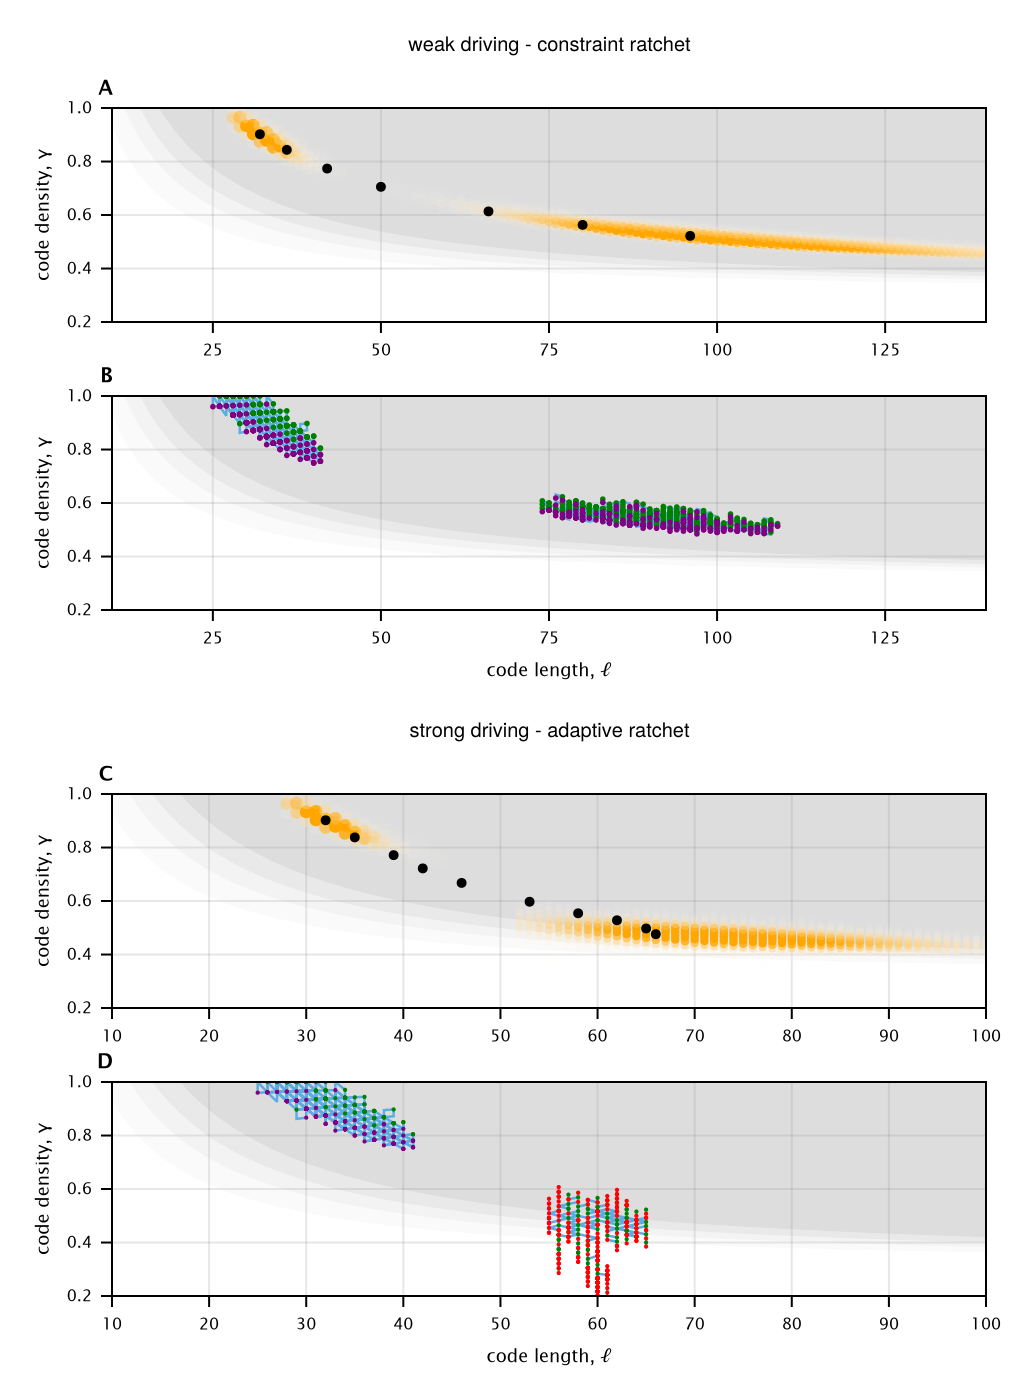

In [112]:
# Fitness with full half binding point
Fitness(γ, l, c=c0) = f0 / (1 + exp(-gap * l/l0* (γ - γ50(l)))) - c * l

# Find optimal length from length substitution rates
function lstar(κ, N=1000, lmax=300)
    # Get ML coding density
    gammastarlist = [γ_star(l,κ, N) for l in 1:lmax]
    # Get functional sites
    functposlist = [(1 > gammastarlist[i] > γ50(l))  for (i, l) in enumerate(1:lmax)]
    # Get coding density of functional sites
    gammafunclist = gammastarlist[functposlist]
    # Get minimal length of functional sites
    lm = findfirst(functposlist)
    
    # Get fitness at ML coding density
    flist = cumsum([log(v_plus(γ_star(l - 1, κ, N), l-1) / v_minus(γ_star(l, κ, N), l)) for l in lm:lmax])
    # Get fitness at ML coding density in strong driving regime
    flistSC = cumsum([log(v_plus_SC(γ_star(l - 1, κ, N), l-1) / v_minus_SC(γ_star(l, κ, N), l)) for l in lm:lmax])

    # ML code length
    lst = argmax(flist) + lm - 1
    # Effective selective coefficient for length increase mutation
    seffpluslist = [seffplus(l, κ) for l in lm:lmax]
    # Cummulative selection coefficients
    fpluslist = cumsum(seffpluslist)

    # Effective selective coefficient for length decrease mutation
    seffminuslist = [seffminus(l, κ) for l in lm:lmax]
    # Cummulative selection coefficients
    fminuslist = - cumsum(seffminuslist)
    return lm, lst, gammastarlist, flist, fpluslist, fminuslist, flistSC
end


# Initate data frame
df = DataFrame(
    κ=Float64[], 
    c=Float64[], 
    γ_star=Float64[], 
    l_star=Int64[], 
    v_tot=Float64[], 
    flist=[], 
    lm=Int64[],
    fpluslist=[],
    fminuslist=[]
)


# Run computations
for κ in [0, 0.2, 0.5, 1, 2, 5, 10, 15, 20, 22, 30, 50]
    for _c in [1, 0.7, 0.5, 0.35, 0.2, 0.14, 0.1]
        global c0 = _c/2N
        lm, lst, flist, fpluslist, fminuslist = lstar(κ)[[1, 2, 4, 5, 6]]
        gst = γ_star(lst, κ)
        v_tot = v_plus_star(lst, κ) + v_minus_star(lst, κ)
        push!(
            df, 
            Dict(
                :κ => κ, 
                :c => _c, 
                :γ_star => gst, 
                :l_star => lst, 
                :v_tot => v_tot, 
                :flist=>flist, 
                :lm => lm,
                :fpluslist => fpluslist,
                :fminuslist => fminuslist
            )
        )
    end
end


# Add plots

lines!(ax, df[df.c .== 1, :κ], df[df.c .== 1, :lm], label="full half binding point")

axislegend(ax, position=:rb)
fig

In [113]:
df.κ |> unique

12-element Vector{Float64}:
  0.0
  0.2
  0.5
  1.0
  2.0
  5.0
 10.0
 15.0
 20.0
 22.0
 30.0
 50.0

### Figure 3

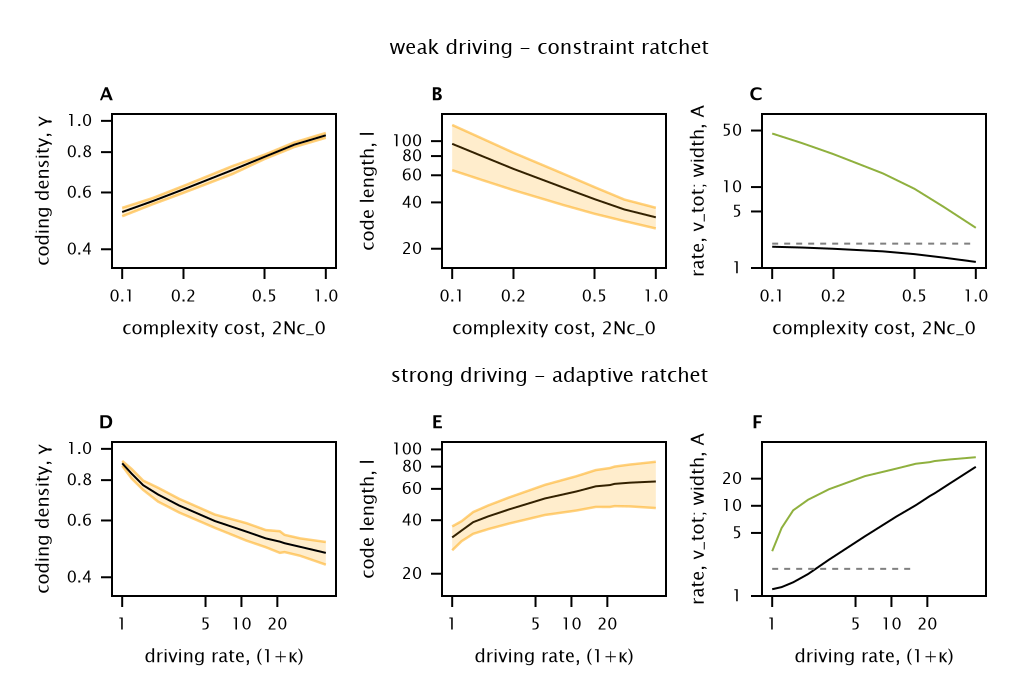

In [114]:
# Figure 
fig = Figure(size = (509, 350))
g0 = fig[1, 1] = GridLayout()
# First Row
l1 = g0[1, 1] = GridLayout()
g01 = g0[2, 1] = GridLayout()
# Second Row
l2 = g0[3, 1] = GridLayout()
g02 = g0[4, 1] = GridLayout()

# A
g1 = g01[1, 1] = GridLayout()

ax1 = Axis(
    g1[1, 1],
    yscale=log10, 
    xscale=log10,
    xminorgridvisible = false,
    yminorgridvisible = false,
    xgridvisible = false,
    ygridvisible = false,
    #aspect=1
)
# B
g2 = g01[1, 2] = GridLayout()

ax2 = Axis(
    g2[1, 1],
    yscale=log10, 
    xscale=log10,
    xminorgridvisible = false,
    yminorgridvisible = false,
    xgridvisible = false,
    ygridvisible = false,
    #aspect=1
)
# C
g3 = g01[1, 3] = GridLayout()

ax3 = Axis(
    g3[1, 1],
    yscale=log10, 
    xscale=log10,
    xminorgridvisible = false,
    yminorgridvisible = false,
    xgridvisible = false,
    ygridvisible = false,
    #aspect=1
)

# D
g4 = g02[1, 1] = GridLayout()

ax4 = Axis(
    g4[1, 1],
    yscale=log10, 
    xscale=log10,
    xminorgridvisible = false,
    yminorgridvisible = false,
    xgridvisible = false,
    ygridvisible = false,
    #aspect=1
)
# E
g5 = g02[1, 2] = GridLayout()

ax5 = Axis(
    g5[1, 1],
    yscale=log10, 
    xscale=log10,
    xminorgridvisible = false,
    yminorgridvisible = false,
    xgridvisible = false,
    ygridvisible = false,
    #aspect=1
)
# F
g6 = g02[1, 3] = GridLayout()

ax6 = Axis(
    g6[1, 1],
    yscale=log10, 
    xscale=log10,
    xminorgridvisible = false,
    yminorgridvisible = false,
    xgridvisible = false,
    ygridvisible = false,
    #aspect=1
)

# Panel A
_df = df[df.κ .== 0, :]

# Compute standard deviation
γ_dev = Float64[]
for l in _df.l_star
    γ_list, psi_list = Ψ_k(l, 0, N)
    inds = map(x -> x > (maximum(psi_list) - 1), psi_list)
    gl = γ_list[inds]
    push!(γ_dev, (maximum(gl) - maximum([minimum(gl), γ50(l)])) / 2)
end

band!(
    ax1,
    _df.c, 
    _df.γ_star .+ γ_dev, 
    _df.γ_star .- γ_dev,
    color=(:orange, 0.2)
)

lines!(
    ax1,
    _df.c,  
    _df.γ_star .- γ_dev,
    color=(:orange, 0.5)
)

lines!(
    ax1,
    _df.c, 
    _df.γ_star .+ γ_dev,
    color=(:orange, 0.5)
)

lines!(
    ax1, 
    _df.c, 
    _df.γ_star,
    linewidth=1,
    color="black"
)


ax1.xlabel = "complexity cost, 2Nc_0"
ax1.yticks = [0.4, 0.6, 0.8, 1]
ax1.xticks = [0.1, 0.2, 0.5, 1]
ylims!(ax1, 0.35, 1.05)
ax1.ylabel = "coding density, γ"

# Panel B
l_dev = Float64[]
for (i, l) in enumerate(_df.l_star)
    lm = _df.lm[i]
    inds = Int64.(collect(maximum([l - ceil(l/5), lm]):l + ceil(l/5)))
    y = _df.flist[i][inds .- lm .+ 1]
    f = Polynomials.fit(inds, y, 2)
    push!(l_dev, (-f[2]) ^(-1/2))
end

lines!(
    ax2, 
    _df.c,
    _df.l_star,
    linewidth=1,
    color="black"
)

band!(
    ax2,
    _df.c, 
    _df.l_star .+ l_dev, 
    _df.l_star .- l_dev,
    color=(:orange, 0.2)
)

lines!(
    ax2,
    _df.c,  
    _df.l_star .- l_dev,
    color=(:orange, 0.5)
)

lines!(
    ax2,
    _df.c, 
    _df.l_star .+ l_dev,
    color=(:orange, 0.5)
    )

ax2.xlabel = "complexity cost, 2Nc_0"
ax2.ylabel = "code length, l"
ax2.yticks = [20, 40, 60, 80, 100]
ax2.xticks = [0.1, 0.2, 0.5, 1]
ylims!(ax2, 15, 150)

# Panel C

lines!(
    ax3,
    _df.c,
    _df.l_star .* (1 .- _df.γ_star),
    linewidth=1,
    color="#8fb03e"
    )

lines!(
    ax3,
    _df.c,
    _df.v_tot,
    linewidth=1,
    color="black"
    )

lines!(
    ax3,
    [0.1, 1],
    [2, 2],
    linewidth=1,
    color="grey",
    linestyle=:dash
    )


ax3.yticks = [1, 5, 10, 50]
ax3.xticks = [0.1, 0.2, 0.5, 1]
ax3.xlabel = "complexity cost, 2Nc_0"
ax3.ylabel = "rate, v_tot; width, A"
ylims!(ax3, 1, 80)

_df = df[df.c .== 1., :]

γ_dev = Float64[]
for (l, κ) in zip(_df.l_star, _df.κ)
    γ_list, psi_list = Ψ_k(Int64(l), κ, N)
    inds = map(x -> x > (maximum(psi_list) - 1), psi_list)
    gl = γ_list[inds]
    push!(γ_dev, (maximum(gl) - maximum([minimum(gl), γ50(l)])) / 2)
end

l_dev = Float64[]
for (i, l) in enumerate(_df.l_star)
    lm = _df.lm[i]
    inds = Int64.(collect(maximum([l - ceil(l/5), lm]):l + ceil(l/5)))
    y = _df.flist[i][inds .- lm .+ 1]
    f = Polynomials.fit(inds, y, 2)
    push!(l_dev, (-f[2]) ^(-1/2))
end

# Panel D

band!(
    ax4,
    1 .+ _df.κ, 
    _df.γ_star .+ γ_dev, 
    _df.γ_star .- γ_dev,
    color=(:orange, 0.2)
)

lines!(
    ax4,
    1 .+ _df.κ,  
    _df.γ_star .- γ_dev,
    color=(:orange, 0.5)
)

lines!(
    ax4,
    1 .+ _df.κ, 
    _df.γ_star .+ γ_dev,
    color=(:orange, 0.5)
)

lines!(
    ax4, 
    1 .+ _df.κ, 
    _df.γ_star,
    linewidth=1,
    color="black"
)
ax4.xlabel = "driving rate, (1+κ)"
ax4.ylabel = "coding density, γ"
ax4.yticks = [0.4, 0.6, 0.8, 1]
ax4.xticks = [1, 5, 10, 20]
ylims!(ax4, 0.35, 1.05)


# Panel E

lines!(
    ax5, 
    1 .+ _df.κ,
    _df.l_star,
    linewidth=1,
    color="black"
)

band!(
    ax5,
    1 .+ _df.κ, 
    _df.l_star .+ l_dev, 
    _df.l_star .- l_dev,
    color=(:orange, 0.2)
)

lines!(
    ax5,
    1 .+ _df.κ,  
    _df.l_star .- l_dev,
    color=(:orange, 0.5)
)

lines!(
    ax5,
    1 .+ _df.κ, 
    _df.l_star .+ l_dev,
    color=(:orange, 0.5)
)

ax5.xlabel = "driving rate, (1+κ)"
ax5.ylabel = "code length, l"
ax5.yticks = [20, 40, 60, 80, 100]
ax5.xticks = [1, 5, 10, 20]
ylims!(ax5, 15, 110)

# Panel F
    
lines!(
    ax6,
    1 .+_df.κ,
    _df.l_star .* (1 .- _df.γ_star),
    linewidth=1,
    color="#8fb03e"
    )

lines!(
    ax6,
    1 .+_df.κ,
    _df.v_tot,
    linewidth=1,
    color="black"
    )

lines!(
    ax6,
    [1, 15],
    [2, 2],
    linewidth=1,
    color="grey",
    linestyle=:dash
    )

ax6.yticks = [1, 5, 10, 20]
ax6.xticks = [1, 5, 10, 20]
ax6.xlabel = "driving rate, (1+κ)"
ax6.ylabel = "rate, v_tot; width, A"
ylims!(ax6, 1, 51)



Label(l1[1, :], "weak driving - constraint ratchet", fontsize = 10, font=Font, tellwidth=false)
Label(l2[1, :], "strong driving - adaptive ratchet", fontsize = 10, font=Font, tellwidth=false)



for (label, layout) in zip(["A", "B", "C", "D", "E", "F"], [g1, g2, g3, g4, g5, g6])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 9,
        font = Font_bold,
        padding = (0, 0, 5, 0),
        halign = :right,
        valign = :bottom,
        #tellheight = false
    )
end

rowgap!(g0, 10)
colgap!(g01, 10)
colgap!(g02, 10)

save("../figures/figure3.pdf", fig)

fig

### Figure 4

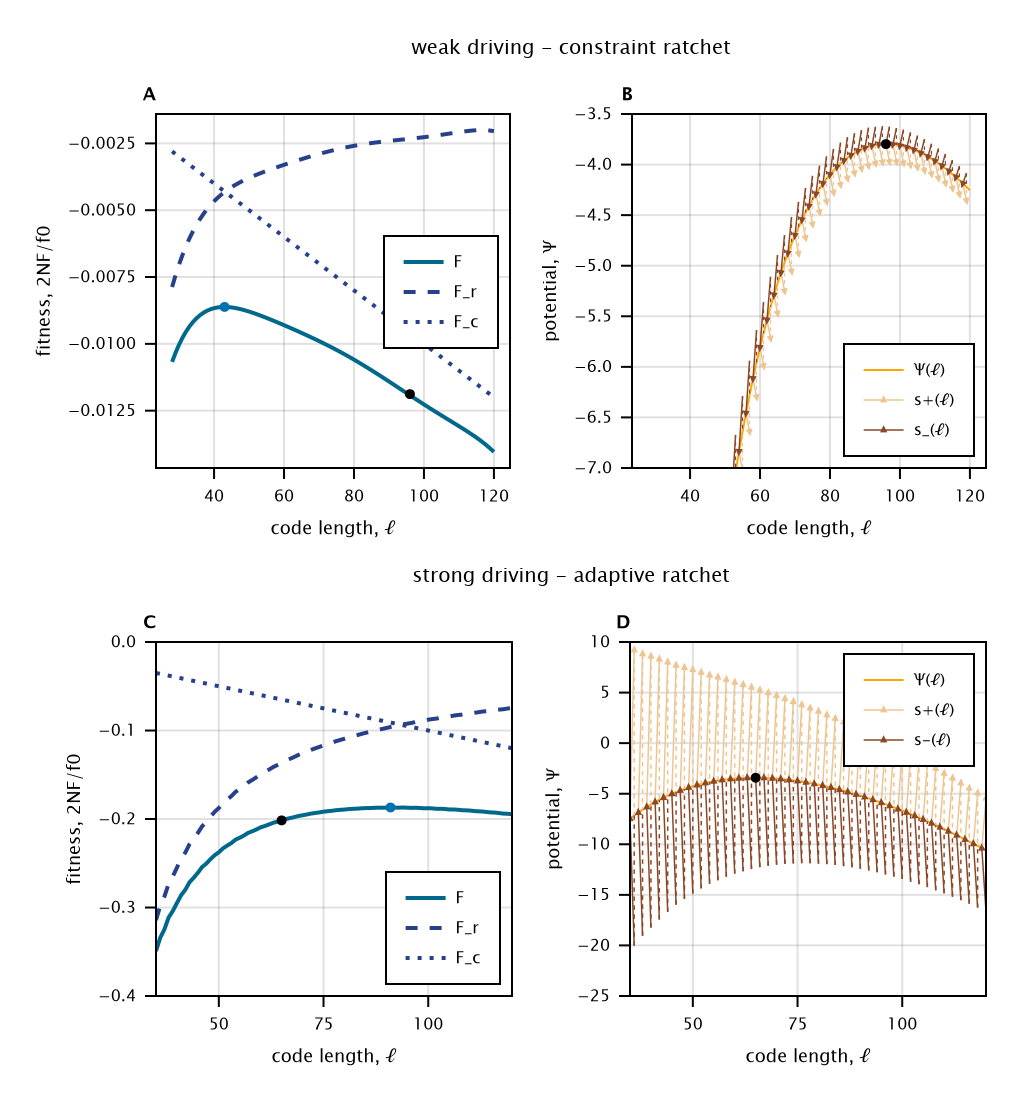

In [115]:
# Figure canvas
fig = Figure(size=(509, 550))
g0 = fig[1, 1] = GridLayout()
# First row
l1 = g0[1, 1] = GridLayout()
g01 = g0[2, 1] = GridLayout()
# Second row
l2 = g0[3, 1] = GridLayout()
g02 = g0[4, 1] = GridLayout()

# A
g1 = g01[1, 1] = GridLayout()
ax1 = Axis(g1[1, 1])

# B
g2 = g01[1, 2] = GridLayout()
ax2 = Axis(g2[1, 1])

# C
g3 = g02[1, 1] = GridLayout()
ax3 = Axis(g3[1, 1])

# D
g4 = g02[1, 2] = GridLayout()
ax4 = Axis(g4[1, 1])

# Maximum length to plot
lmax_plot = 120

# Complexity cost for first row
_c0 = 0.1/2N

# Get points
_df = df[(df.c .== 0.1 ) .& (df.κ .== 0), :]
# Get minimal length of functional sites
lm = _df[1, :lm]
# Get ML coding length
lst = _df[1, :l_star]
# Get total Fitness 
fst = [Fitness.(γ_star(l, 0), l, _c0)/f0 - 1  for l in lm:lmax_plot]
# Get recognition Fitness 
pb = [(Fitness.(γ_star(l, 0), l, _c0) +_c0*l)/f0 - 1  for l in lm:lmax_plot]
# Get complexity cost
fc = [-_c0*l/f0   for l in lm:lmax_plot]
# Smooth curve
p_fst = Polynomials.fit(lm:lmax_plot, fst, 6)
p_pb = Polynomials.fit(lm:lmax_plot, pb, 6)

# Plot total fitness
lines!(
    ax1, 
    lm:lmax_plot, 
    p_fst.(lm:lmax_plot), 
    label="F",
    linewidth=2,
    color=:deepskyblue4
)

# Plot maximum fitness
scatter!(
    ax1,
    [collect(lm:lmax_plot)[argmax(p_fst.(lm:lmax_plot))]],
    [maximum(p_fst.(lm:lmax_plot))],
    markersize=7
)

# Plot fitness at ML coding length
scatter!(
    ax1,
    [lst],
    [fst[lst-lm+1]],
    color=:black,
    markersize=7
)

# Plot recognition fitness
lines!(
    ax1, 
    lm:lmax_plot, 
    p_pb.(lm:lmax_plot), 
    label="F_r",
    linewidth=2,
    linestyle=:dash,
    color=:royalblue4
)

# Plot complexity cost
lines!(
    ax1, 
    lm:lmax_plot, 
    fc, 
    label="F_c",
    linewidth=2,
    linestyle=:dot,
    color=:royalblue4
)

# Annotate plot
ax1.xlabel = "code length, ℓ"
ax1.ylabel = "fitness, 2NF/f0"
axislegend(ax1, position=:rc, padding=(10, 10, 3, 3))


# Panel B
# Get Fitness 
flist = _df[1, :flist][1:lmax_plot-lm+1]
flist_norm = log(sum(exp.(flist)))
fpluslist = _df[1, :fpluslist][1:lmax_plot-lm+1]  .*2N
fminuslist = _df[1, :fminuslist][1:lmax_plot-lm+1] .*2N

lines!(
    ax2,
    lm:lmax_plot,
    (flist .- flist_norm),
    color=:orange,
    linewidth=1,
    label="Ψ(ℓ)"
)

arrows!(
    ax2,
    lm:2:lmax_plot-1,
    ((flist .- flist_norm)[1:end-1])[1:2:end],
    ones(length(lm:lmax_plot-1))[1:2:end],
    (fpluslist[2:end] .- fpluslist[1:end-1])[1:2:end],
    color=:burlywood2,
    label="s+(ℓ)",
    arrowsize=5,
    linewidth=0.75
    )

arrows!(
    ax2,
    lm+1:2:lmax_plot,
    ((flist .- flist_norm)[1:end-1] .- (fminuslist[1:end-1] .- fminuslist[2:end]))[1:2:end],
    (-1 .* ones(length(lm:lmax_plot-1)))[1:2:end],
    (fminuslist[1:end-1] .- fminuslist[2:end])[1:2:end],
    color=:sienna4,
    label="s_(ℓ)",
    arrowsize=5,
    linewidth=0.75
    )


for l in lm:2:lmax_plot-1
    lines!(
        ax2,
        [l+1, l+1],
        [
            (flist .- flist_norm)[l-lm+1] + (fpluslist[2:end] .- fpluslist[1:end-1])[l-lm+1], 
            (flist .- flist_norm)[l-lm+2]],
        color=:burlywood2,
        linestyle=:dash,
        linewidth=0.6
        )
    
    lines!(
        ax2,
        [l+1, l+1],
        [
            (flist .- flist_norm)[l-lm+1] - (fminuslist[1:end-1] .- fminuslist[2:end])[l-lm+1], 
            (flist .- flist_norm)[l-lm+2]],
        color=:sienna4,
        linestyle=:dash,
        linewidth=0.6
        )
    
end



scatter!(
    ax2,
    [lst],
    [(flist .- flist_norm)[lst-lm+1]],
    color=:black,
    markersize=7
)


axislegend(ax2, position=:rb, padding=(10, 10, 3, 3))
ax2.xlabel = "code length, ℓ"
ax2.ylabel = "potential, Ψ"
ylims!(ax2, -7, -3.5)

# Panel C
_c0 = 1/2N

_df = df[(df.c .== 1. ) .& (df.κ .== 30), :]
lm = _df[1, :lm]
lst = _df[1, :l_star]
fst = [Fitness.(γ_star(l, 30), l, _c0)/f0 - 1  for l in lm:lmax_plot]
pb = [(Fitness.(γ_star(l, 30), l, _c0) +_c0*l)/f0 - 1  for l in lm:lmax_plot]
fc = [-_c0*l/f0   for l in lm:lmax_plot]
p_fst = Polynomials.fit(lm:lmax_plot, fst, 5)
p_pb = Polynomials.fit(lm:lmax_plot, pb, 5)


lines!(
    ax3, 
    lm:lmax_plot, 
    fst, 
    label="F",
    linewidth=2,
    color=:deepskyblue4
)


scatter!(
    ax3,
    [collect(lm:lmax_plot)[argmax(fst)]],
    [maximum(fst)],
    markersize=7
)

scatter!(
    ax3,
    [lst],
    [fst[lst-lm+1]],
    color=:black,
    markersize=7
)

lines!(
    ax3, 
    lm:lmax_plot, 
    pb, 
    label="F_r",
    linewidth=2,
    linestyle=:dash,
    color=:royalblue4
)

lines!(
    ax3, 
    lm:lmax_plot, 
    fc, 
    label="F_c",
    linewidth=2,
    linestyle=:dot,
    color=:royalblue4
)

ax3.xlabel = "code length, ℓ"
ax3.ylabel = "fitness, 2NF/f0"
axislegend(ax3, position=:rb, padding=(10, 10, 3, 3))
xlims!(ax3, 35, lmax_plot)
ylims!(ax3, -0.4, 0)

# Panel D
flist = _df[1, :flist][1:lmax_plot-lm+1]
flist_norm = log(sum(exp.(flist)))


fpluslist = _df[1, :fpluslist][1:lmax_plot-lm+1]  .*2N
fminuslist = _df[1, :fminuslist][1:lmax_plot-lm+1] .*2N

lines!(
    ax4,
    lm:lmax_plot,
    (flist .- flist_norm),
    color=:orange,
    linewidth=1,
    label="Ψ(ℓ)"
)

arrows!(
    ax4,
    lm:2:lmax_plot-1,
    ((flist .- flist_norm)[1:end-1])[1:2:end],
    (ones(length(lm:lmax_plot-1)))[1:2:end],
    ((fpluslist[2:end] .- fpluslist[1:end-1]))[1:2:end],
    color=:burlywood2,
    label="s+(ℓ)",
    arrowsize=5,
    linewidth=0.75
    )

arrows!(
    ax4,
    lm+1:2:lmax_plot,
    ((flist .- flist_norm)[1:end-1] .- (fminuslist[1:end-1] .- fminuslist[2:end]))[1:2:end],
    (-1 .* ones(length(lm:lmax_plot-1)))[1:2:end],
    (fminuslist[1:end-1] .- fminuslist[2:end])[1:2:end],
    color=:sienna4,
    label="s-(ℓ)",
    arrowsize=5,
    linewidth=0.75
    )



for l in lm:2:lmax_plot-1
    lines!(
        ax4,
        [l+1, l+1],
        [
            (flist .- flist_norm)[l-lm+1] + (fpluslist[2:end] .- fpluslist[1:end-1])[l-lm+1], 
            (flist .- flist_norm)[l-lm+2]],
        color=:burlywood2,
        linestyle=:dash,
        linewidth=0.75
        )
    
    lines!(
        ax4,
        [l+1, l+1],
        [
            (flist .- flist_norm)[l-lm+1] - (fminuslist[1:end-1] .- fminuslist[2:end])[l-lm+1], 
            (flist .- flist_norm)[l-lm+2]],
        color=:sienna4,
        linestyle=:dash,
        linewidth=0.75
        )
    
end

scatter!(
    ax4,
    [lst],
    [(flist .- flist_norm)[lst-lm+1]],
    color=:black,
    markersize=7
)

axislegend(ax4, position=:rt, padding=(10, 10, 3, 3))
ax4.xlabel = "code length, ℓ"
ax4.ylabel = "potential, Ψ"
ylims!(ax4, -25, 10)
xlims!(ax4, 35, lmax_plot)

Label(l1[1, :], "weak driving - constraint ratchet", fontsize = 10, font=Font, tellwidth=false)
Label(l2[1, :], "strong driving - adaptive ratchet", fontsize = 10, font=Font, tellwidth=false)



for (label, layout) in zip(["A", "B", "C", "D"], [g1, g2, g3, g4])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 9,
        font = Font_bold,
        padding = (0, 0, 5, 0),
        halign = :right,
        valign = :bottom,
        #tellheight = false
    )
end

rowgap!(g0, 10)
colgap!(g01, 15)
colgap!(g02, 15)


#save("../figures/figure4.pdf", fig)
fig

### Simulation Steps (Figure 2)

In [116]:
function init(l, κ)
    γ_list, plist = Ψ_k(l, κ, N)
    
    # normalize for stability
    
    plist = BigFloat.(plist)
    norm = sum(exp.(plist))
    pcumlist = cumsum(exp.(plist) ./ norm)
    return (findfirst(map(x -> x > rand(), pcumlist))-1) / l
end

init (generic function with 1 method)

In [117]:
function traitstep(γ, l, κ, track)
    
    p_up = up(γ, l, κ) / (up(γ, l, κ) + um(γ, l, κ))
    if γ < 1
        p_pe = γ_0(n)/(1 - γ_0(n)) * (1 - γ) * κ / up(γ, l, κ)
    else
        p_pe = 0
    end
    if γ > 0
        p_me =  γ * κ / um(γ, l, κ)
    else
        p_me = 0
    end
    if rand() < p_up
        pt = (l,  γ + 1/l)
        if rand() < p_pe
            # external degradation
            push!(track.elist, pt)
            track.next += 1
            track.admutlist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]) , track.admutlist)
            track.negmutlist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]) , track.negmutlist)
        else
            # adaptive mutation
            push!(track.admutlist, pt)
            track.nad += 1
            track.elist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.elist)
            track.negmutlist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.negmutlist)
        end
    else
        pt = (l, γ - 1/l)
        if rand() < p_me
            # external improvement
            push!(track.elist, pt)
            track.next += 1
            track.admutlist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.admutlist)
            track.negmutlist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.negmutlist)
        else
            # deleterious mutation
            push!(track.negmutlist, pt)
            track.ndel += 1
            track.elist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.elist)
            track.admutlist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.admutlist)
        end
    end
    return pt
end

traitstep (generic function with 1 method)

In [118]:
rl(γ, l, κ) = (v_plus(γ, l) + v_minus(γ, l))/(up(γ, l, κ) + um(γ, l, κ))

rl (generic function with 1 method)

In [119]:
function lengthstep(γ, l, κ, track)
    p_up = v_plus(γ, l) / (v_plus(γ, l) + v_minus(γ, l))
    p_pp = v_pp(γ, l) / v_plus(γ, l)
    p_mp = v_mp(γ, l) / v_minus(γ, l)
    if rand() < p_up
        # extension
        if rand() < p_pp
            pt = (l + 1, γ_pp(γ, l))
            push!(track.adlist, pt)
            track.neglist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.neglist)
            push!(track.slist, s_pp(γ, l))
        else
            pt = (l + 1, γ_pm(γ, l))
            push!(track.neglist, pt)
            track.adlist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.adlist)
            push!(track.slist, s_pm(γ, l))
        end
        
    else
        # compression
        if rand() < p_mp
            pt = (l - 1, γ_mp(γ, l))
            push!(track.adlist, pt)
            track.neglist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.neglist)
            push!(track.slist, s_mp(γ, l))
        else
            pt = (l - 1, γ_mm(γ, l))
            push!(track.neglist, pt)
            track.adlist = filter(x -> (~(x[2] ≈ pt[2])) || (x[1] != pt[1]), track.adlist)
            push!(track.slist, s_mm(γ, l))
        end
    end
    return pt
end
            
        

lengthstep (generic function with 1 method)

Designate object to track simulation.

In [120]:
mutable struct tracker
    slist::Vector{Float64}
    elist::Vector{Tuple{Int64, Float64}}
    admutlist::Vector{Tuple{Int64, Float64}}
    negmutlist::Vector{Tuple{Int64, Float64}}
    adlist::Vector{Tuple{Int64, Float64}}
    neglist::Vector{Tuple{Int64, Float64}}
    lengthchanges::Int64
    next::Int64
    nad::Int64
    ndel::Int64
    tracker() = new(
        Float64[],
        Tuple{Int64, Float64}[],
        Tuple{Int64, Float64}[],
        Tuple{Int64, Float64}[],
        Tuple{Int64, Float64}[],
        Tuple{Int64, Float64}[],
        0,
        0,
        0,
        0 
    )
end



Run a trajectory.

In [121]:
function evol(l, κ, t, ν)
    γ = init(l, κ) 
    path = [(l, γ)]
    track = tracker()
    for i in 1:t
        l, γ = traitstep(γ, l, κ, track)
        push!(path, (l, γ))
        if rand() < ν * rl(γ, l, κ)
            l, γ = lengthstep(γ, l, κ, track)
            push!(path, (l, γ))
            track.lengthchanges += 1
        end
    end
    return path, track
end

evol (generic function with 1 method)

# Run simulations

In [133]:
# Run 1: 2Nc0 = 1, κ = 0
c0 = 1/2N
path, track = evol(30, 0, 2000, 0.1);
_df = df[(df.κ .== 0) .& (df.c .== c0), ["lm", "flist"]]
Ψ1 = [Ψ_k(l, 0, N) for l in 10:140]

# Run 3: 2Nc0 = 1, κ = 30
path3, track3 = evol(60, 30, 2000, 0.1);
_df3 = df[(df.κ .== 30) .& (df.c .== c0), ["lm", "flist"]]
Ψ3 = [Ψ_k(l, 30, N) for l in 10:140]

# Run 2: 2Nc0 = 0.1, κ = 0
c0 = .1/2N
path2, track2 = evol(90, 0, 2000, 0.1);
_df2 = df[(df.κ .== 0) .& (df.c .== c0), ["lm", "flist"]]
Ψ2 = [Ψ_k(l, 0, N) for l in 10:140]
lm2, lst2, flist2 = lstar(0, N, 140)[[1, 2, 4]];

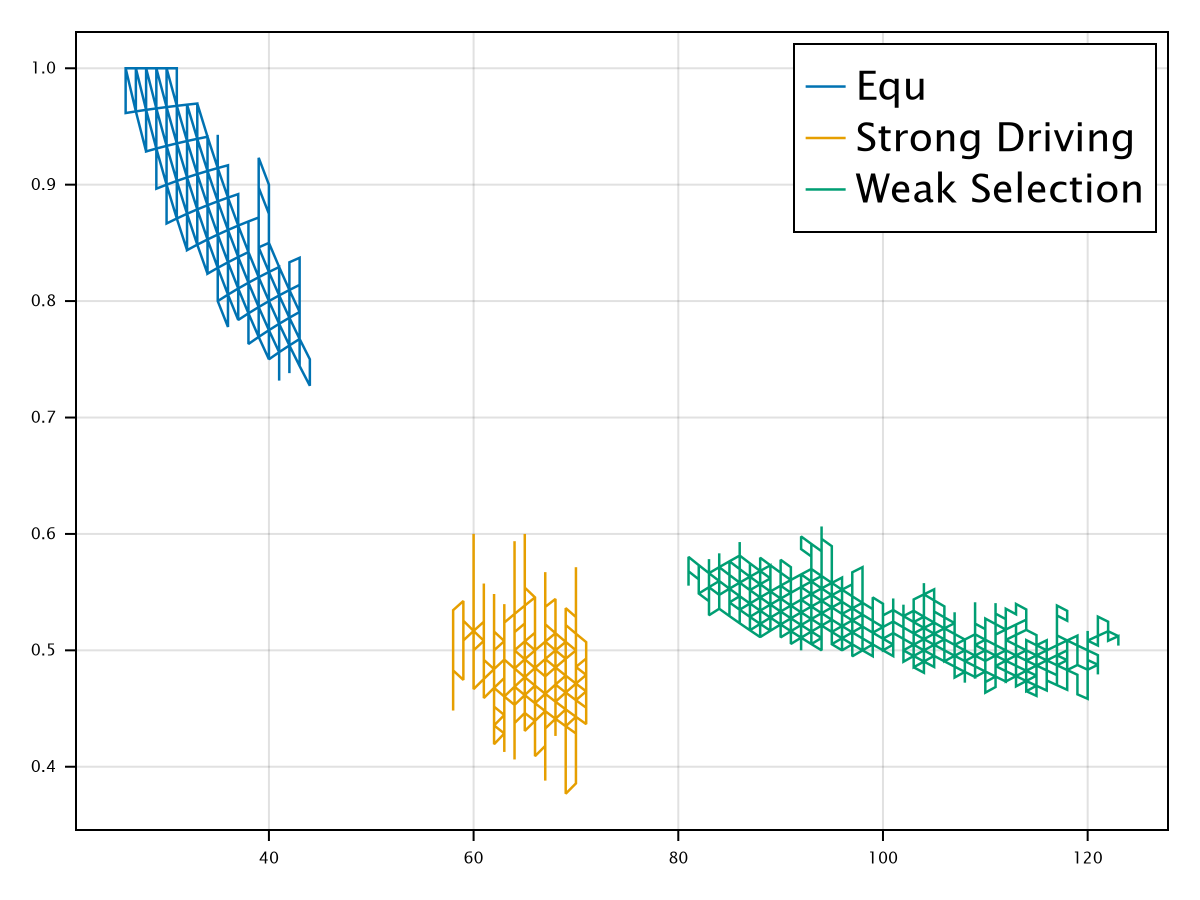

In [134]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, path, label="Equ")
lines!(ax, path3, label="Strong Driving")
lines!(ax, path2, label="Weak Selection")
axislegend(ax, labelsize=20)

fig

In [135]:
cmap_orange = range(RGBA(1.0,1.0,1.0,0), RGBA{Float64}(1.0,0.65,0.0,1.0), length=100)
cmap_gray = range(RGBA(1.0,1.0,1.0,0.2), RGBA{Float64}(0.65,0.65,0.65,.5), length=100);

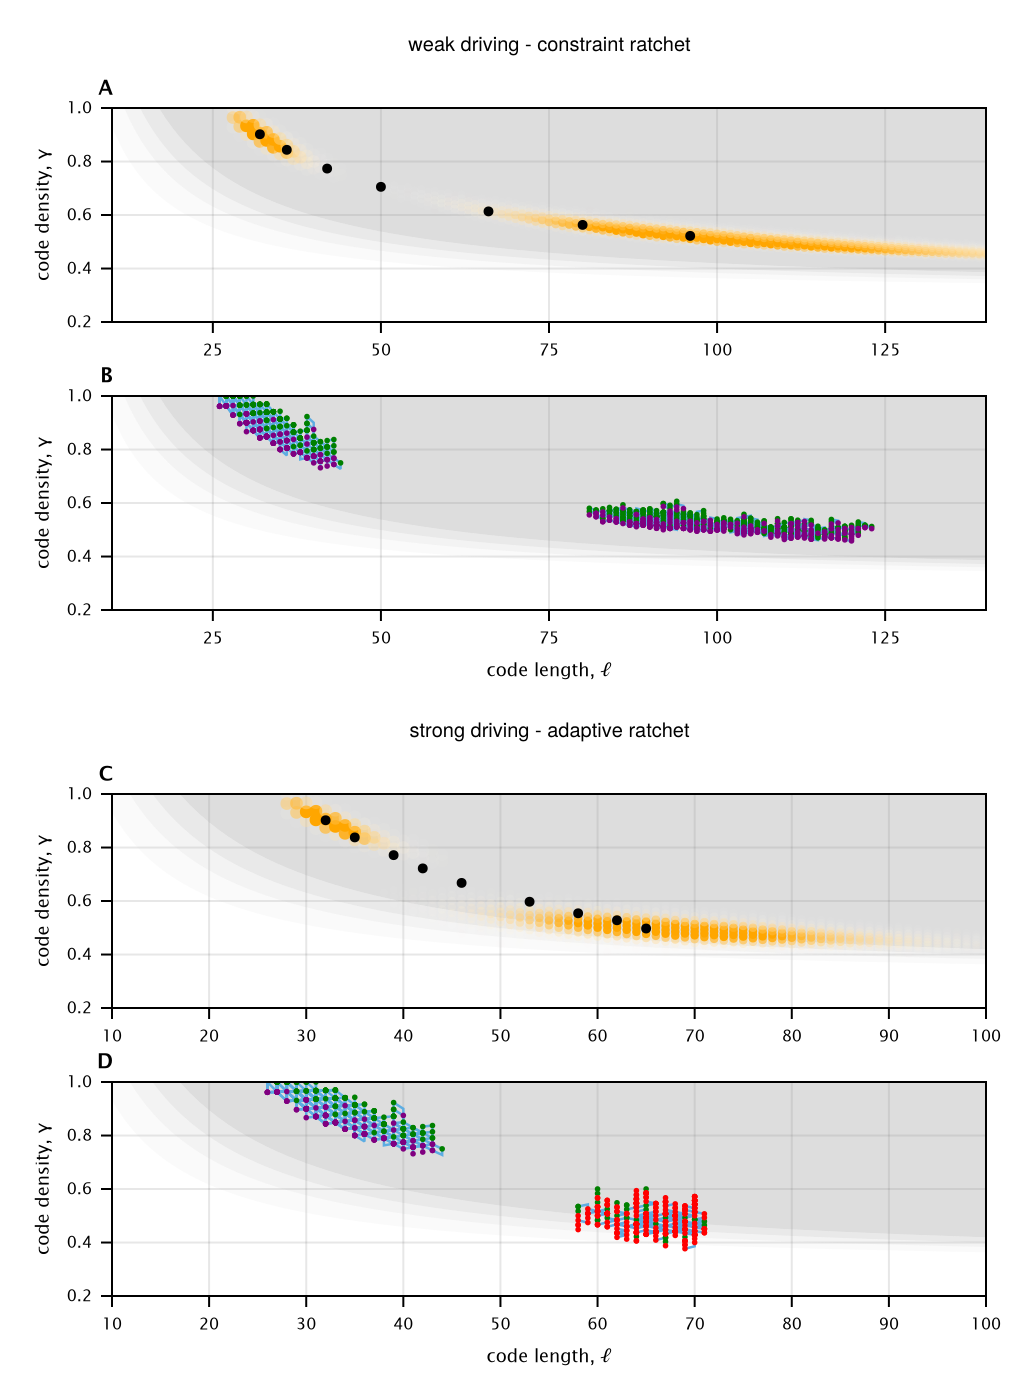

In [138]:
fig = Figure(size=(509, 700))
g0 = fig[1, 1] = GridLayout()

l1 = g0[1, 1] = GridLayout()
g01 = g0[2, 1] = GridLayout()
l2 = g0[3, 1] = GridLayout()
g02 = g0[4, 1] = GridLayout()

g1 = g01[1, 1] = GridLayout()
g2 = g01[2, 1] = GridLayout()

g3 = g02[1, 1] = GridLayout()
g4 = g02[2, 1] = GridLayout()

ax1 = Axis(g1[1, 1])
ax2 = Axis(g2[1, 1])
ax3 = Axis(g3[1, 1])
ax4 = Axis(g4[1, 1])


F = hcat([[Fitness(γ, l, 0)  for l in 10:140] for γ in 0:0.01:1]...)

#contour!(ax1, 10:120, 0:0.01:1, F, color="grey", extendhigh=:auto, levels=6, linewidth=1)
contourf!(ax1, 10:140, 0:0.01:1, F, colormap=cmap_gray, extendhigh=:auto, levels=5)#, linewidth=3)
_df = df[df.κ .== 0, ["l_star", "γ_star", "flist", "lm", "c"]]


for (Ψ, c, s) in zip([Ψ1, Ψ2], [1/2N, 0.1/2N], [9, 6])
    flist, lm = _df[_df.c .≈ 2N*c, :][1, ["flist", "lm"]]

    flist_norm = log(sum(exp.(BigFloat.(flist[1:140-lm+1]))))
    Q = []
    
    for (i, l) in enumerate(10:140)
        _F = Fitness.(0:1/l:1, l, 0)
        Ψ_norm = log(sum(exp.(BigFloat.(Ψ[i][2]))) * 1/l)
        if l < lm
            push!(Q, Ψ[i][2] .* 0)
        else
            push!(Q, exp.(Ψ[i][2] .+ flist[l-lm+1] .- Ψ_norm .- flist_norm) .* _F)
        end
    end
    
    x = vcat([fill(l, l+1) for l in 10:140]...)
    y = vcat([collect(0:1/l:1) for l in 10:140]...)
    scatter!(ax1, x, y, color=vcat(Q...), markersize=s, colormap=cmap_orange, colorrange=(0.0, 0.7maximum(vcat(Q...))))

end
scatter!(ax1, _df.l_star, _df.γ_star, color="black", markersize=7)
ylims!(ax1, 0.2, 1)
ax1.ylabel = "code density, γ"


contourf!(ax2, 10:140, 0:0.01:1, F, colormap=cmap_gray, extendhigh=:auto, levels=5)#, linewidth=3)

lines!(ax2, path, color="#5dade2")
lines!(ax2, path2, color="#5dade2")

scatter!(ax2, track.admutlist, color="green", markersize=4)
scatter!(ax2, track.negmutlist, color="purple", markersize=4)
scatter!(ax2, track.elist, color="orange", markersize=4)

scatter!(ax2, track2.admutlist, color="green", markersize=4)
scatter!(ax2, track2.negmutlist, color="purple", markersize=4)
scatter!(ax2, track2.elist, color="orange", markersize=4)

ylims!(ax2, 0.2, 1)

ax2.xlabel = "code length, ℓ"
ax2.ylabel = "code density, γ"


contourf!(ax3, 10:140, 0:0.01:1, F, colormap=cmap_gray, extendhigh=:auto, levels=5)#, linewidth=3)

_df = df[df.c .== 1., ["l_star", "γ_star", "flist", "lm", "κ"]]
c0 = 1/2N

for (Ψ, kappa, s) in zip([Ψ1, Ψ3], [0, 30], [9, 6])
    flist, lm = _df[_df.κ .== kappa, :][1, ["flist", "lm"]]
    if lm > 50
        l_min = 60
    else
        l_min = lm
    end
    flist = cumsum([log(v_plus(γ_star(l - 1, kappa, N), l-1) / v_minus(γ_star(l, kappa, N), l)) for l in lm:140])
    flist_norm = log(sum(exp.(flist)))
    Q = []
    for (i, l) in enumerate(10:140)
        Ψ_norm = log(sum(exp.(BigFloat.(Ψ[i][2]))) * 1/l)
        _F = Fitness.(0:1/l:1, l, 0)
        #push!(Q, exp.(Ψ[i][2] .+ flist[i] .- Ψ_norm) .* _F)
        if l < lm
            #push!(Q, exp.(BigFloat.(Ψ[i][2] .+ flist[1] .- Ψ_norm)) .* _F)
            push!(Q, Ψ[i][2] .* 0)
        else
            push!(Q, exp.(BigFloat.(Ψ[i][2] .+ flist[l-lm+1] .- Ψ_norm)) .* _F)
        end
    end
    
    x = vcat([fill(l, l+1) for l in 10:140]...)
    y = vcat([collect(0:1/l:1) for l in 10:140]...)
    scatter!(ax3, x, y, color=vcat(Q...), markersize=s, colormap=cmap_orange, colorrange=(0.0, 0.7maximum(vcat(Q...))))
end

temp_df = df[(df.κ .!= 22) .& (df.κ .!= 20) .& (df.c .== c0*2N) .& (df.κ .!= 50), :]
scatter!(ax3, temp_df.l_star, temp_df.γ_star, color="black", markersize=7)
ylims!(ax3, 0.2, 1)
xlims!(ax3, 10, 100)
ax3.ylabel = "code density, γ"


contourf!(ax4, 10:140, 0:0.01:1, F, colormap=cmap_gray, extendhigh=:auto, levels=5)#, linewidth=3)

lines!(ax4, path, color="#5dade2")
lines!(ax4, path3, color="#5dade2")

scatter!(ax4, track.admutlist, color="green", markersize=4)
scatter!(ax4, track.negmutlist, color="purple", markersize=4)
scatter!(ax4, track.elist, color="red", markersize=4)

scatter!(ax4, track3.admutlist, color="green", markersize=4)
scatter!(ax4, track3.negmutlist, color="purple", markersize=4)
scatter!(ax4, track3.elist, color="red", markersize=4)
ylims!(ax4, 0.2, 1)
xlims!(ax4, 10, 100)
ax4.xlabel = "code length, ℓ"
ax4.ylabel = "code density, γ"


Label(
    l1[1, :], 
    "weak driving - constraint ratchet", 
    fontsize = 10, 
    tellwidth=false
)
Label(
    l2[1, :], 
    "strong driving - adaptive ratchet", 
    fontsize = 10, 
    tellwidth=false
)


for (label, layout) in zip(["A", "B", "C", "D"], [g1, g2, g3, g4])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 10,
        font = Font_bold,
        padding = (0, 0, 5, 0),
        halign = :right,
        valign = :bottom,
        #tellheight = false
    )
end

rowgap!(g0, 1, 10)
rowgap!(g0, 3, 10)
rowgap!(g01, 1)
rowgap!(g02, 1)

save("figures/figure2_rev.pdf", fig)

fig

### Figure S4

In [151]:
# Run 1: 2Nc0 = 1, κ = 10
c0 = 10/2N
path, track = evol(10, 10, 2000, 0.1);

# Run 2: 2Nc0 = 1, κ = 0
c0 = 1/2N
path2, track2 = evol(70, 100, 2000, 0.1);

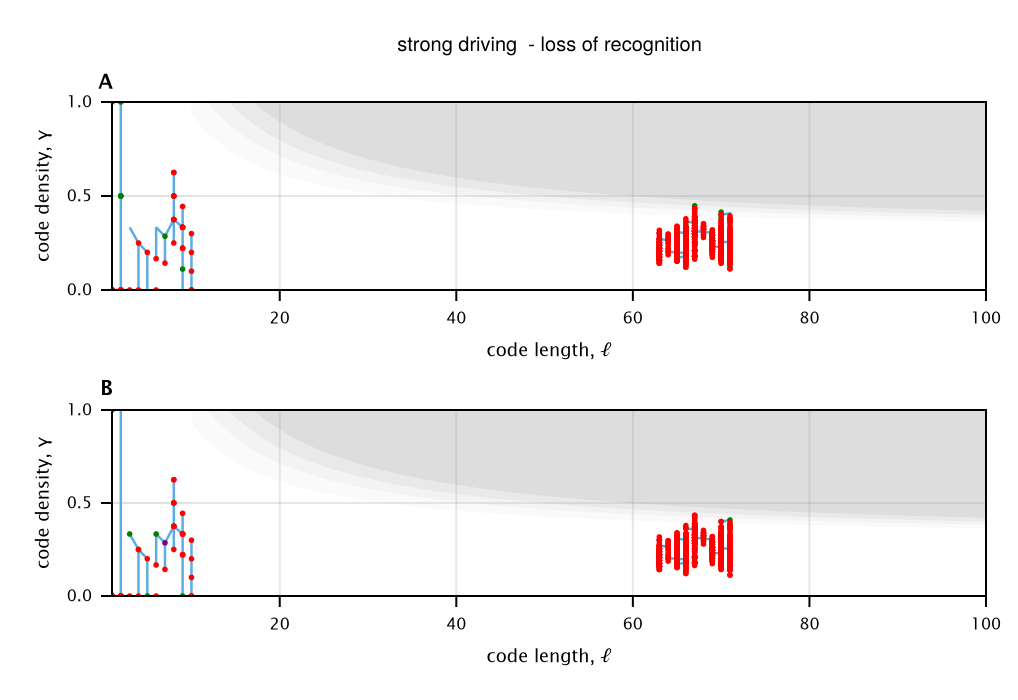

In [152]:
fig = Figure(size=(509, 350))

g01 = fig[1, 1] = GridLayout()


g1 = g01[1, 1] = GridLayout()
g2 = g01[2, 1] = GridLayout()


ax1 = Axis(g1[1, 1])
ax2 = Axis(g2[1, 1])


F = hcat([[Fitness(γ, l, 0)  for l in 10:100] for γ in 0:0.01:1]...)


contourf!(ax1, 10:100, 0:0.01:1, F, colormap=cmap_gray, extendhigh=:auto, levels=5)#, linewidth=2)

lines!(ax1, path, color="#5dade2")
lines!(ax1, path2, color="#5dade2")

scatter!(ax1, track.admutlist, color="green", markersize=4)
scatter!(ax1, track.negmutlist, color="purple", markersize=4)
scatter!(ax1, track.elist, color="red", markersize=4)

scatter!(ax1, track2.admutlist, color="green", markersize=4)
scatter!(ax1, track2.negmutlist, color="purple", markersize=4)
scatter!(ax1, track2.elist, color="red", markersize=4)

#ylims!(ax1, 0, 1)

ax1.xlabel = "code length, ℓ"
ax1.ylabel = "code density, γ"


contourf!(ax2, 10:100, 0:0.01:1, F, colormap=cmap_gray, extendhigh=:auto, levels=5)#, linewidth=2)

lines!(ax2, path, color="#5dade2")
lines!(ax2, path2, color="#5dade2")

scatter!(ax2, track.adlist, color="green", markersize=4)
scatter!(ax2, track.neglist, color="purple", markersize=4)
scatter!(ax2, track.elist, color="red", markersize=4)

scatter!(ax2, track2.adlist, color="green", markersize=4)
scatter!(ax2, track2.neglist, color="purple", markersize=4)
scatter!(ax2, track2.elist, color="red", markersize=4)
#ylims!(ax2, 0.2, 1)
ax2.xlabel = "code length, ℓ"
ax2.ylabel = "code density, γ"


Label(
    g01[0, :], 
    "strong driving  - loss of recognition", 
    fontsize = 10, 
    tellwidth=false
)

for (label, layout) in zip(["A", "B", "C", "D"], [g1, g2, g3, g4])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 10,
        font = Font_bold,
        padding = (0, 0, 5, 0),
        halign = :right,
        valign = :bottom,
        #tellheight = false
    )
end

rowgap!(g01, 7)
rowgap!(g02, 7)
save("figures/figureS4.pdf", fig)
fig

## Figure S1

BigFloat[-8.956320789712551242943670518931514589106166657242803227665460464596100319558251, -6.928888313374746344510562756161802505216803797311628143273030285621179121523618, -5.263757312598229901781692975741330890327943043066367102147656072792989517702608, -4.049901765354289447883180394637980823886160247732394727146183882560845393164301, -3.100655487950173024100876116990011226704179109996048792746631036319181411873153, -2.464120870069450180060844794195455970267394507231893508267939833637502048634771, -2.037726590081833632115895542351243086542365049363634192874838274957616528566297, -1.825775780104918767650698869108673653984338137362495355424394170122002056341522, -1.805752222629470429133360862362455702672421228993030859006145617228337859641878, -1.939238404442723219279915205505407524000745884697346246154104192116455319022694, -2.237958314632474034119169279333746444820378171375254440608845201465469968330034, -2.684533806049161231923917794674225144363793867036564715387479178144800889806

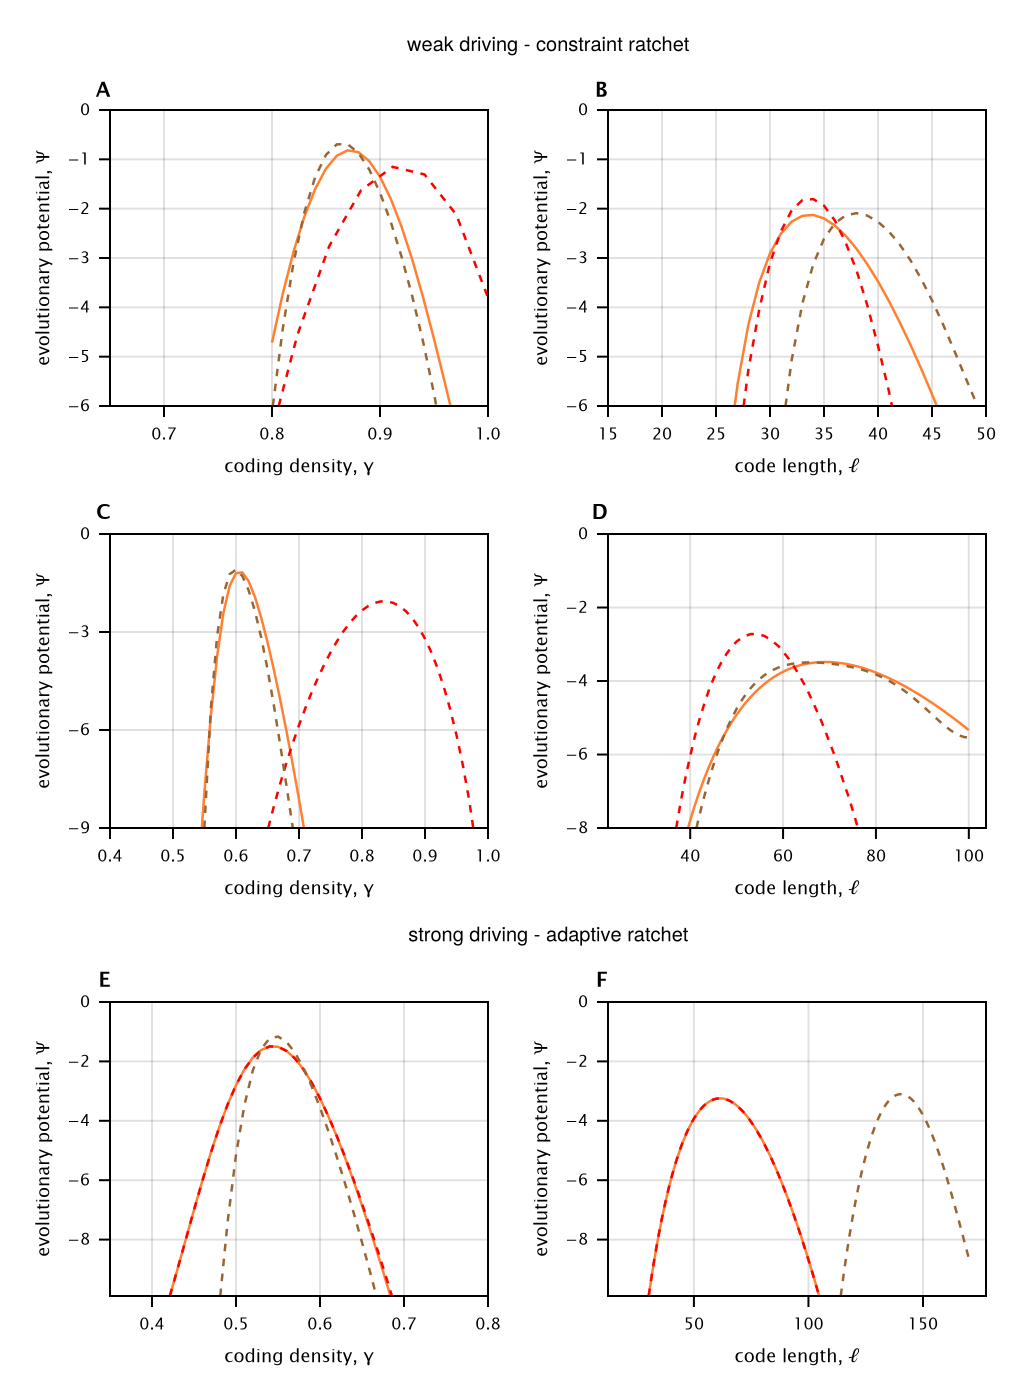

In [53]:
fig = Figure(size=(509, 700))
g0 = fig[1, 1] = GridLayout()

l1 = g0[1, 1] = GridLayout()
g01 = g0[2, 1] = GridLayout()
g02 = g0[3, 1] = GridLayout()
l2 = g0[4, 1] = GridLayout()
g03 = g0[5, 1] = GridLayout()

g1 = g01[1, 1] = GridLayout()
g2 = g02[1, 1] = GridLayout()
g3 = g03[1, 1] = GridLayout()

g4 = g01[1, 2] = GridLayout()
g5 = g02[1, 2] = GridLayout()
g6 = g03[1, 2] = GridLayout()

ax1 = Axis(g1[1, 1])
ax1.xlabel = "coding density, γ"
ax1.ylabel = "evolutionary potential, Ψ"

ax2 = Axis(g2[1, 1])
ax2.xlabel = "coding density, γ"
ax2.ylabel = "evolutionary potential, Ψ"

ax3 = Axis(g3[1, 1])
ax3.xlabel = "coding density, γ"
ax3.ylabel = "evolutionary potential, Ψ"

ax4 = Axis(g4[1, 1])
ax4.xlabel = "code length, ℓ"
ax4.ylabel = "evolutionary potential, Ψ"

ax5 = Axis(g5[1, 1])
ax5.xlabel = "code length, ℓ"
ax5.ylabel = "evolutionary potential, Ψ"

ax6 = Axis(g6[1, 1])
ax6.xlabel ="code length, ℓ"
ax6.ylabel = "evolutionary potential, Ψ"


# Left column, coding density
function strong_driving_app(γ, l, κ)
  return sum([log(big((up(_γ - 1/l, l-1, κ) / (1 - γ_0(n))) / (κ * (_γ)))) for _γ in 1/l:1/l:γ])
end

function full_dist(γ, l, κ)
  return sum([log((up(_γ - 1/l, l-1, κ) / (1 - γ_0(n))) / um(_γ, l, κ)) for _γ in 1/l:1/l:γ])
end

function weak_driving_app(γ, l, κ)
  return 2N / (1 + κ) * Fitness(γ, l) + H(γ, l)
end


# Panel A
κ = .1
c0 = 1/2N
y_range_plot = 0.8:0.01:1 |> collect

_l = lstar(κ)[2]
γ_range = 1/_l:1/_l:1 |> collect
fit_inds = map(x -> 0.8 < x < 0.95, γ_range)


y1 = [full_dist(γ, _l, κ) for γ in γ_range]
y2 = [strong_driving_app(γ, _l, κ) for γ in γ_range]
y3 = [weak_driving_app(γ, _l, κ) for γ in γ_range]

f3 = Polynomials.fit(γ_range, y3, 10)
y3_fit = f3.(y_range_plot)


y1 = y1 .- log(sum(exp.(big.(y1))))
y2 = y2 .- log(sum(exp.(y2)))
y3 = y3 .- log(sum(exp.(y3)))

f1 = Polynomials.fit(γ_range[fit_inds], y1[fit_inds], 10)
y1_fit = f1.(y_range_plot)

f3 = Polynomials.fit(γ_range[fit_inds], y3[fit_inds], 10)
y3_fit = f3.(y_range_plot)

#lines!(ax1, γ_range, y1, label="Full", color="#FF7F33")
lines!(ax1, y_range_plot, y1_fit, label="Full", color="#FF7F33")
lines!(ax1, γ_range, y2, label="Strong", linestyle=:dash, color="#ff0000")
lines!(ax1, y_range_plot, y3_fit, label="Weak", linestyle=:dash, color="#996633")


xlims!(ax1, 0.65, 1)
ylims!(ax1, -6, 0)


# Panel C
κ = .1
c0 = 0.2/2N

y_range_plot = 0.5:0.01:1 |> collect

_l = lstar(κ)[2]
γ_range = 1/_l:1/_l:1 |> collect

fit_inds = map(x -> 0.5 < x < 0.98, γ_range)

y1 = [full_dist(γ, _l, κ) for γ in γ_range]
y2 = [strong_driving_app(γ, _l, κ) for γ in γ_range]
y3 = [weak_driving_app(γ, _l, κ) for γ in γ_range]

y1 = y1 .- log(sum(exp.(y1)))
y2 = y2 .- log(sum(exp.(y2)))
y3 = y3 .- log(sum(exp.(y3)))

f1 = Polynomials.fit(γ_range[fit_inds], y1[fit_inds], 15)
y1_fit = f1.(y_range_plot)

f2 = Polynomials.fit(γ_range[fit_inds], y2[fit_inds], 15)
y2_fit = f2.(y_range_plot)

f3 = Polynomials.fit(γ_range[fit_inds], y3[fit_inds], 15)
y3_fit = f3.(y_range_plot)


lines!(ax2, y_range_plot, y1_fit, label="Full", color="#FF7F33")
lines!(ax2, y_range_plot, y2_fit, label="Strong", linestyle=:dash, color="#ff0000")
lines!(ax2, y_range_plot, y3_fit, label="Weak", linestyle=:dash, color="#996633")

#axislegend(ax2)
xlims!(ax2, 0.4, 1)
ylims!(ax2, -9, 0)



################# Panel E
κ = 15
c0 = 1/2N

_l = lstar(κ)[2]
γ_range = 1/_l:1/_l:1 |> collect
y_range_plot = 0.41:0.01:0.79 |> collect

fit_inds = map(x -> 0.4 < x < 0.8, γ_range)

y1 = [full_dist(γ, _l, κ) for γ in γ_range]
y2 = [strong_driving_app(γ, _l, κ) for γ in γ_range]
y3 = [weak_driving_app(γ, _l, κ) for γ in γ_range]


y1 = y1 .- log(sum(exp.(y1)))
y2 = y2 .- log(sum(exp.(y2)))
y3 = y3 .- log(sum(exp.(y3)))

f1 = Polynomials.fit(γ_range[fit_inds], y1[fit_inds], 15)
y1_fit = f1.(y_range_plot)

f2 = Polynomials.fit(γ_range[fit_inds], y2[fit_inds], 15)
y2_fit = f2.(y_range_plot)

f3 = Polynomials.fit(γ_range[fit_inds], y3[fit_inds], 15)
y3_fit = f3.(y_range_plot)

lines!(ax3, y_range_plot, y1_fit, label="Full", color="#FF7F33")
lines!(ax3, y_range_plot, y2_fit, label="Strong", linestyle=:dash, color="#ff0000")
lines!(ax3, y_range_plot, y3_fit, label="Weak", linestyle=:dash, color="#996633")

#axislegend(ax3)
xlims!(ax3, 0.35, 0.8)
ylims!(ax3, -9.9, 0)

# Right column, coding length
function l_full_dist(κ, lm, lmax=100)
  flist = cumsum([log(v_plus(γ_star(l - 1, κ), l-1) / v_minus(γ_star(l, κ), l)) for l in lm:lmax])
  return flist
end


function l_weak_driving_app(κ, lm, lmax=100)
  s = [(1 + κ) / (γ_0(n) * (1 - γ_0(n))) * (γ_star(l, κ) - γ_0(n)) for l in lm:lmax]
  #return [l0 * ϵ0 / 2  * (2N * f0  - 1/ϵ0 * s[i]) - 2N * c0 * l for (i, l) in enumerate(lm:lmax)]
  return [(2N * f0 *  l0/2) * ((Fitness(γ_star(l, κ), l, c0) + c0*l)/f0 - 1) - 2N * c0 * l for l in lm:lmax]
end

function l_strong_driving_app(κ, lm, lmax=100)
  return cumsum([log(big(v_plus_SC(γ_star(l - 1, κ), l-1) / v_minus_SC(γ_star(l, κ), l))) for l in lm:lmax])
end

######################## Panel B ################
 
c0 = 1/2N
κ = .1

lm = lstar(κ)[1]
lmax = 50


l_range = lm:lmax |> collect


l_range_fit = 23:50

y1 = l_full_dist(κ, lm, lmax)
y2 = l_strong_driving_app(κ, lm, lmax)
y3 = l_weak_driving_app(κ, lm, lmax)

y3 = y3 .- minimum(y3)

y1 = y1 .- log(sum(exp.(y1)))
y2 = y2 .- log(sum(exp.(big.(y2))))
y3 = y3 .- log(sum(exp.(y3)))

fit_inds = map(x -> 28 <= x <= 50, l_range)

f1 = Polynomials.fit(l_range[fit_inds], y1[fit_inds], 10)
y1_fit = f1.(l_range[fit_inds])

f3 = Polynomials.fit(l_range[fit_inds], y3[fit_inds], 6)
y3_fit = f3.(l_range[fit_inds])

println(y2)

lines!(ax4, l_range, y1, label="Full", color="#FF7F33")
lines!(ax4, l_range, y2, label="Strong", linestyle=:dash, color="#ff0000")
#lines!(ax4, l_range[fit_inds], y1_fit, label="Full", color="#FF7F33")
lines!(ax4, l_range[fit_inds], y3_fit, label="Weak", linestyle=:dash, color="#996633")
#lines!(ax4, l_range, y3, label="Weak", linestyle=:dash, color="#996633")

ylims!(ax4, -6, 0)
xlims!(ax4, 15, 50)



######### Panel D #########
c0 = 0.2/2N
κ = 0.1

lm = lstar(κ)[1]
lmax = 100
l_range = lm:lmax |> collect
y1 = l_full_dist(κ, lm, lmax)

y2 = l_strong_driving_app(κ, lm, lmax)

y3 = l_weak_driving_app(κ, lm, lmax)
y3 = y3 .- minimum(y3)

y1 = y1 .- log(sum(exp.(y1)))
y2 = y2 .- log(sum(exp.(big.(y2))))
y3 = y3 .- log(sum(exp.(y3)))

fit_inds = map(x -> 36 <= x <= 100, l_range)

f3 = Polynomials.fit(l_range[fit_inds], y3[fit_inds], 6)
y3_fit = f3.(l_range[fit_inds])

lines!(ax5, l_range, y1, label="Full", color="#FF7F33")
lines!(ax5, l_range, y2, label="Strong", linestyle=:dash, color="#ff0000")
lines!(ax5, l_range[fit_inds], y3_fit, label="Weak", linestyle=:dash, color="#996633")


ylims!(ax5, -8, 0)



######## Panel F ##########
c0 = 1/2N
κ = 15

lm = lstar(κ)[1]
lmax = 170
l_range = lm:lmax |> collect
y1 = l_full_dist(κ, lm, lmax)

y2 = l_strong_driving_app(κ, lm, lmax)

y3 = l_weak_driving_app(κ, lm, lmax)
y3 = y3 .- minimum(y3)

# Normalize

y1 = y1 .- log(sum(exp.(y1)))
y2 = y2 .- log(sum(exp.(y2)))
y3 = y3 .- log(sum(exp.(big.(y3))))

fit_inds = map(x -> 90 <= x <= 170, l_range)

f3 = Polynomials.fit(l_range[fit_inds], y3[fit_inds], 6)
y3_fit = f3.(l_range[fit_inds])

lines!(ax6, l_range, y1, label="Full", color="#FF7F33")
lines!(ax6, l_range, y2, label="Strong", linestyle=:dash, color="#ff0000")
lines!(ax6, l_range[fit_inds], y3_fit, label="Weak", linestyle=:dash, color="#996633")


ylims!(ax6, -9.9, 0)

Label(
    l1[1, :], 
    "weak driving - constraint ratchet", 
    fontsize = 10, 
    tellwidth=false
)
Label(
    l2[1, :], 
    "strong driving - adaptive ratchet", 
    fontsize = 10, 
    tellwidth=false
)


rowgap!(g0, 11)
colgap!(g01, 20)
colgap!(g02, 20)
colgap!(g03, 20)

for (label, layout) in zip(["A", "B", "C", "D", "E", "F"], [g1, g4, g2, g5, g3, g6])
  Label(layout[1, 1, TopLeft()], label,
      fontsize = 10,
      font = Font_bold,
      padding = (0, 0, 5, 0),
      halign = :right,
      valign = :bottom,
      #tellheight = false
  )
end

save("../figures/figureS1.pdf", fig)

fig

## Figure S2

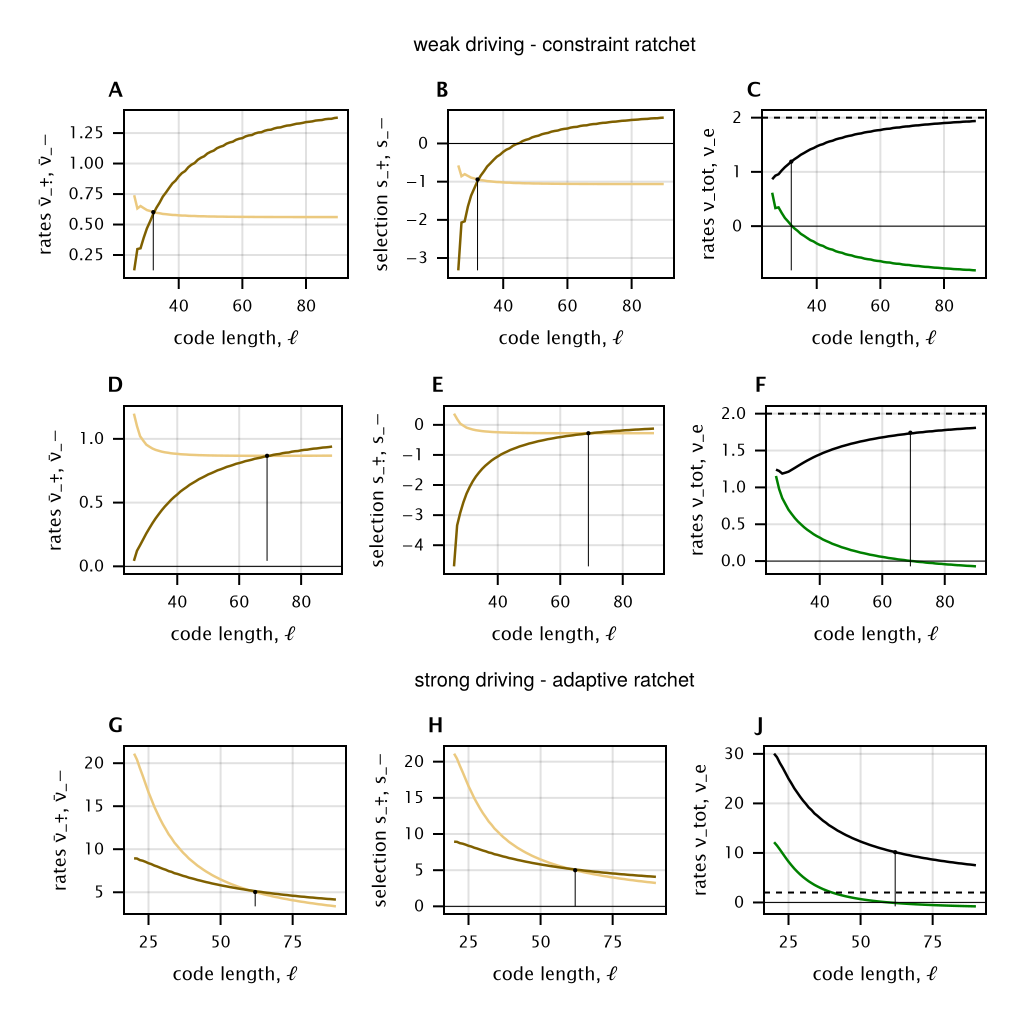

In [164]:
fig = Figure(size=(509, 509))
g0 = fig[1, 1] = GridLayout()

l1 = g0[1, 1] = GridLayout()
g01 = g0[2, 1] = GridLayout()
g02 = g0[3, 1] = GridLayout()
l2 = g0[4, 1] = GridLayout()
g03 = g0[5, 1] = GridLayout()

g1 = g01[1, 1] = GridLayout()
g2 = g01[1, 2] = GridLayout()
g3 = g01[1, 3] = GridLayout()

g4 = g02[1, 1] = GridLayout()
g5 = g02[1, 2] = GridLayout()
g6 = g02[1, 3] = GridLayout()

g7 = g03[1, 1] = GridLayout()
g8 = g03[1, 2] = GridLayout()
g9 = g03[1, 3] = GridLayout()


Label(
    l1[1, :], 
    "weak driving - constraint ratchet", 
    fontsize = 10, 
    tellwidth=false
)
Label(
    l2[1, :], 
    "strong driving - adaptive ratchet", 
    fontsize = 10, 
    tellwidth=false
)
rowgap!(l1, 7)
rowgap!(l2, 7)

ax1 = Axis(g1[1, 1])
ax1.xlabel = "code length, ℓ"
ax1.ylabel = "rates ν̄_⨥, ν̄_−"

ax2 = Axis(g2[1, 1])
ax2.xlabel = "code length, ℓ"
ax2.ylabel = "selection s_⨥, s_−"

ax3 = Axis(g3[1, 1])
ax3.xlabel ="code length, ℓ"
ax3.ylabel = "rates ν_tot, ν_e"

ax4 = Axis(g4[1, 1])
ax4.xlabel = "code length, ℓ"
ax4.ylabel = "rates ν̄_⨥, ν̄_−"

ax5 = Axis(g5[1, 1])
ax5.xlabel = "code length, ℓ"
ax5.ylabel = "selection s_⨥, s_−"

ax6 = Axis(g6[1, 1])
ax6.xlabel = "code length, ℓ"
ax6.ylabel = ax3.ylabel = "rates ν_tot, ν_e"

ax7 = Axis(g7[1, 1])
ax7.xlabel = "code length, ℓ"
ax7.ylabel = "rates ν̄_⨥, ν̄_−"

ax8 = Axis(g8[1, 1])
ax8.xlabel = "code length, ℓ"
ax8.ylabel = "selection s_⨥, s_−"

ax9 = Axis(g9[1, 1])
ax9.xlabel = "code length, ℓ"
ax9.ylabel = ax3.ylabel = "rates ν_tot, ν_e"


colgap!(g01, 11)
colgap!(g02, 11)
colgap!(g03, 11)

rowgap!(g0, 11)

# Panel A, B, C
κ = 0
c0 = 1/2N
lm, lst = lstar(κ)[1:2]
l_range = lm-2:90 |> collect

y1 = [v_plus_star(l, κ) for l in l_range]
y2 = [v_minus_star(l, κ) for l in l_range]
ymin = minimum(vcat(y1, y2))

lines!(ax1, l_range, y1, color="#ebc97f")
lines!(ax1, l_range, y2, color="#7f6000")
scatter!(ax1, lst, y1[lst-lm+3], markersize=3, color="black")

ymin = minimum(vcat(y1, y2))
lines!(ax1, [lst, lst], [ymin, y1[lst-lm+3]], color="black", linewidth=0.5)

y1 = 2N .* [seffplus(l, κ) for l in l_range]
y2 = 2N .* [seffminus(l, κ) for l in l_range]

lines!(ax2, l_range, y1, color="#ebc97f")
lines!(ax2, l_range, y2, color="#7f6000")
hlines!(ax2, 0, color="black", linewidth=0.5)
scatter!(ax2, lst, y1[lst-lm+3], markersize=3, color="black")

ymin = minimum(vcat(y1, y2, [0]))
lines!(ax2, [lst, lst], [ymin, y1[lst-lm+3]], color="black", linewidth=0.5)

y1 = [v_plus_star(l, κ) + v_minus_star(l, κ) for l in l_range]
y2 = [v_plus_star(l, κ) - v_minus_star(l, κ) for l in l_range]

lines!(ax3, l_range, y1, color="black")
lines!(ax3, l_range, y2, color="green")

hlines!(ax3, 0, color="black", linewidth=0.5)
hlines!(ax3, 2, color="black", linewidth=1, linestyle=:dash)
scatter!(ax3, lst, y1[lst-lm+3], markersize=3, color="black")
ymin = minimum(vcat(y1, y2, [0]))
lines!(ax3, [lst, lst], [ymin, y1[lst-lm+3]], color="black", linewidth=0.5)



# Panel D, E, F
κ = 0.1
c0 = 0.2/2N
lm, lst = lstar(κ)[1:2]

l_range = lm:90 |> collect
y1 = [v_plus_star(l, κ) for l in l_range]
y2 = [v_minus_star(l, κ) for l in l_range]

lines!(ax4, l_range, y1, color="#ebc97f")
lines!(ax4, l_range, y2, color="#7f6000")
hlines!(ax4, 0, color="black", linewidth=0.5)
scatter!(ax4, lst, y1[lst-lm+3], markersize=3, color="black")

ymin = minimum(vcat(y1, y2))
lines!(ax4, [lst, lst], [ymin, y1[lst-lm+3]], color="black", linewidth=0.5)

y1 = 2N .* [seffplus(l, κ) for l in l_range]
y2 = 2N .* [seffminus(l, κ) for l in l_range]

lines!(ax5, l_range, y1, color="#ebc97f")
lines!(ax5, l_range, y2, color="#7f6000")
scatter!(ax5, lst, y1[lst-lm+3], markersize=3, color="black")

ymin = minimum(vcat(y1, y2, [0]))
lines!(ax5, [lst, lst], [ymin, y1[lst-lm+3]], color="black", linewidth=0.5)

y1 = [v_plus_star(l, κ) + v_minus_star(l, κ) for l in l_range]
y2 = [v_plus_star(l, κ) - v_minus_star(l, κ) for l in l_range]

lines!(ax6, l_range, y1, color="black")
lines!(ax6, l_range, y2, color="green")
scatter!(ax6, lst, y1[lst-lm+3], markersize=3, color="black")

hlines!(ax6, 0, color="black", linewidth=0.5)
hlines!(ax6, 2, color="black", linewidth=1, linestyle=:dash)

ymin = minimum(vcat(y1, y2, [0]))
lines!(ax6, [lst, lst], [ymin, y1[lst-lm+3]], color="black", linewidth=0.5)

# Panel G, H, J
κ = 15
c0 = 1/2N
lm, lst = lstar(κ)[1:2]

l_range = lm:90 |> collect
y1 = [v_plus_star(l, κ) for l in l_range]
y2 = [v_minus_star(l, κ) for l in l_range]

lines!(ax7, l_range, y1, color="#ebc97f")
lines!(ax7, l_range, y2, color="#7f6000")
scatter!(ax7, lst, y1[lst-lm+1], markersize=3, color="black")
ymin = minimum(vcat(y1, y2))
lines!(ax7, [lst, lst], [ymin, y1[lst-lm+1]], color="black", linewidth=0.5)

y1 = 2N .* [seffplus(l, κ) for l in l_range]
y2 = 2N .* [seffminus(l, κ) for l in l_range]

lines!(ax8, l_range, y1, color="#ebc97f")
lines!(ax8, l_range, y2, color="#7f6000")
hlines!(ax8, 0, color="black", linewidth=0.5)
scatter!(ax8, lst, y1[lst-lm+1], markersize=3, color="black")
ymin = minimum(vcat(y1, y2, [0]))
lines!(ax8, [lst, lst], [ymin, y1[lst-lm+1]], color="black", linewidth=0.5)

y1 = [v_plus_star(l, κ) + v_minus_star(l, κ) for l in l_range]
y2 = [v_plus_star(l, κ) - v_minus_star(l, κ) for l in l_range]

lines!(ax9, l_range, y1, color="black")
lines!(ax9, l_range, y2, color="green")
hlines!(ax9, 0, color="black", linewidth=0.5)
hlines!(ax9, 2, color="black", linewidth=1, linestyle=:dash)
scatter!(ax9, lst, y1[lst-lm+1], markersize=3, color="black")
ymin = minimum(vcat(y1, y2, [0]))
lines!(ax9, [lst, lst], [ymin, y1[lst-lm+1]], color="black", linewidth=0.5)


for (label, layout) in zip(["A", "B", "C", "D", "E", "F" ," G", "H", "J"], [g1, g2, g3, g4, g5, g6, g7, g8, g9])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 10,
        font = Font_bold,
        padding = (0, 0, 5, 0),
        halign = :right,
        valign = :bottom,
        #tellheight = false
    )
  end

save("../figures/figureS2.pdf", fig)

fig

## Figure S3

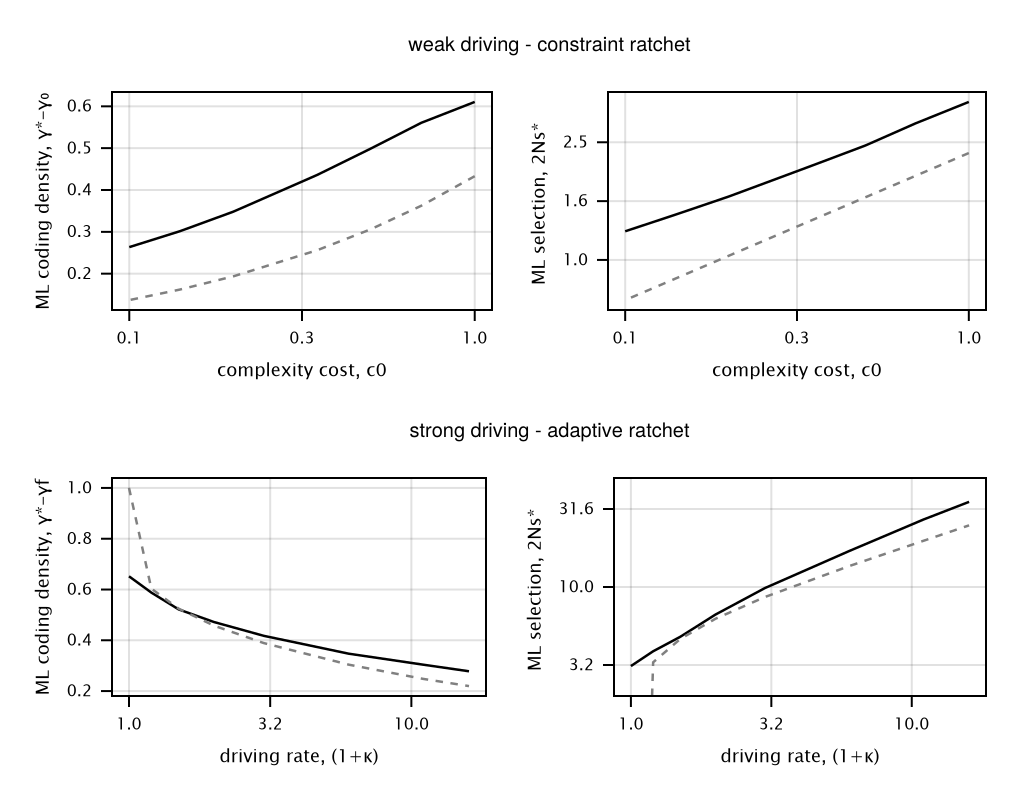

In [166]:
fig = Figure(size=(509, 400))
g0 = fig[1, 1] = GridLayout()

l1 = g0[1, 1] = GridLayout()
g01 = g0[2, 1] = GridLayout()
l2 = g0[3, 1] = GridLayout()
g02 = g0[4, 1] = GridLayout()

g1 = g01[1, 1] = GridLayout()
g2 = g01[1, 2] = GridLayout()

g3 = g02[1, 1] = GridLayout()
g4 = g02[1, 2] = GridLayout()


Label(
    l1[1, :], 
    "weak driving - constraint ratchet", 
    fontsize = 10, 
    tellwidth=false
)
Label(
    l2[1, :], 
    "strong driving - adaptive ratchet", 
    fontsize = 10, 
    tellwidth=false
)
rowgap!(l1, 7)
rowgap!(l2, 7)


c_arr = Float64[1, 0.7, 0.5, 0.35, 0.2, 0.14, 0.1]

ax1 = Axis(g1[1, 1], xscale=log10)#yscale=log10, )
ax1.xlabel = "complexity cost, c0"
ax1.ylabel = "ML coding density, γ*-γ₀"

ax2 = Axis(g2[1, 1], yscale=log10, xscale=log10)
ax2.xlabel = "complexity cost, c0"
ax2.ylabel = "ML selection, 2Ns* "

ax3 = Axis(g3[1, 1], xscale=log10)#yscale=log10, )
ax3.xlabel = "driving rate, (1+κ)"
ax3.ylabel = "ML coding density, γ*-γf"

ax4 = Axis(g4[1, 1], yscale=log10, xscale=log10)
ax4.xlabel = "driving rate, (1+κ)"
ax4.ylabel =  "ML selection, 2Ns* "


# Panel A, B
κ = .10


y1 = Float64[]
y2 = Float64[]

for c_0 in c_arr
    global c0 = c_0 / 2N
    lst = lstar(κ)[2]
    push!(y1, γ_star(lst, κ) - γ_0(n))
    push!(y2, (c_0 * γ_0(n) * (1 - γ_0(n)))^(1/2))
end

lines!(ax1, c_arr, y1, color="black")
lines!(ax1, c_arr, y2, color="grey", linestyle=:dash)

ax1.xtickformat = "{:.1f}"
ax1.ytickformat = "{:.1f}"

y1 = Float64[]
y2 = Float64[]

for c_0 in c_arr
    global c0 = c_0 / 2N
    lst = lstar(κ)[2]
    γ_s = γ_star(lst, κ)
    push!(y1, 2N * (Fitness(γ_s + 1/2lst, lst) - Fitness(γ_s - 1/2lst, lst)))
    push!(y2, (c_0 /(γ_0(n) * (1 - γ_0(n))))^(1/2))
end

lines!(ax2, c_arr, y1, color="black")
lines!(ax2, c_arr, y2, color="grey", linestyle=:dash)

ax2.xtickformat = "{:.1f}"
ax2.ytickformat = "{:.1f}"

κ_arr = [0, 0.2, 0.5, 1, 2, 5, 10, 15]
c0 = 1/2N

y1 = Float64[]
y2 = Float64[]


cpp = 1 - exp(-gap / l0 * (1 - γ_0(n)))
cmp = 1 - exp(-gap / l0 * γ_0(n))
cnu = 2 * sinh(gap / l0 / 2)

function solve_gamma(κ)
   function f!(F, x)
      F[1] =  (x[1] - γ_0(n) ) / (γ_0(n) * (1 - x[1])) * κ - (1 - x[1] +γ_0(n)) / (γ_0(n) * cpp - (1 - x[1]) * cmp) * cnu
   end
   x = nlsolve(f!, [0.5])
   return x.zero[1]
end

for κ in κ_arr
    lst = lstar(κ)[2]
    γ_s = γ_star(lst, κ)
    push!(y1, γ_s - γ_0(n))
    push!(y2, solve_gamma(κ) - γ_0(n))
end

lines!(ax3, 1 .+ κ_arr, y1, color="black")
lines!(ax3, 1 .+ κ_arr, y2, color="grey", linestyle=:dash)
ax3.xtickformat = "{:.1f}"
ax3.ytickformat = "{:.1f}"

y1 = Float64[]
y2 = Float64[]

for κ in κ_arr
    lst = lstar(κ)[2]
    γ_s = γ_star(lst, κ)
    push!(y1, 2N * (Fitness(γ_s + 1/2lst, lst) - Fitness(γ_s - 1/2lst, lst)))
    x = solve_gamma(κ)
    s = (x - γ_0(n))/(γ_0(n) * (1 - x)) * κ
    if s > 0
        push!(y2, s)
    else
        push!(y2, 0.0001)
    end
end

lines!(ax4, 1 .+ κ_arr, y1, color="black")
lines!(ax4, 1 .+ κ_arr, y2, color="grey", linestyle=:dash)
ylims!(ax4, 2, 50)
ax4.xtickformat = "{:.1f}"
ax4.ytickformat = "{:.1f}"

save("../figures/figureS3.pdf", fig)

fig